<a href="https://colab.research.google.com/github/ScienceforLife/Telegram/blob/main/EDA_MME_MUTUALSER_v_20240530.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pointbiserialr

import pandas as pd
import numpy as np
from statsmodels.tools.tools import add_constant

pd.set_option('display.max_columns', None)

#### EDA - MORBILIDAD MATERNA EXTREMA MUTUALSER

##### Carga del dataframe

##### Crear Indice (tipo + id)

In [ ]:
# "C:\Users\s4lco\Desktop\EDA MME MUTUAL\data\df_smh_cleaned.csv"
csv_path = r"/content/df_smh_cleaned.csv"

# Leer el archivo CSV
try:
    df_smh = pd.read_csv(csv_path, sep=",", quotechar='"', na_values=["", "NaN", "nan", "NaT"], parse_dates=True)
    print("Archivo CSV cargado correctamente.")
except FileNotFoundError:
    print(f"Error: El archivo no se encuentra en la ruta proporcionada: {csv_path}")
except pd.errors.EmptyDataError:
    print("Error: El archivo CSV está vacío.")
except pd.errors.ParserError:
    print("Error: Problema de análisis en el archivo CSV.")
except Exception as e:
    print(f"Ocurrió un error inesperado al leer el archivo CSV. Detalles: {e}")

# Crear la columna `id_pac` concatenando `TIPO` y `DOCUMENTO`
try:
    df_smh['TIPO'] = df_smh['TIPO'].astype(str)
    df_smh['DOCUMENTO'] = df_smh['DOCUMENTO'].astype(str)
    df_smh['id_pac'] = df_smh['TIPO'] + df_smh['DOCUMENTO']

    # Eliminar las columnas originales
    df_smh.drop(['TIPO', 'DOCUMENTO'], axis=1, inplace=True)
    print("Las columnas TIPO y DOCUMENTO se han eliminado correctamente.")

    # Convertir `id_pac` en el índice
    df_smh.set_index('id_pac', inplace=True)
    print("La columna 'id_pac' se ha utilizado correctamente como índice.")
except KeyError as e:
    print(f"Error: La columna {e} no está presente en el DataFrame.")
except Exception as e:
    print(f"Se ha producido un error inesperado: {e}")

# Verificar la estructura del DataFrame
df_smh.info()

Archivo CSV cargado correctamente.
Las columnas TIPO y DOCUMENTO se han eliminado correctamente.
La columna 'id_pac' se ha utilizado correctamente como índice.
<class 'pandas.core.frame.DataFrame'>
Index: 44850 entries, CC1131479215 to CC1002295941
Data columns (total 41 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   FUM                                          44850 non-null  object 
 1   FPP                                          44850 non-null  object 
 2   SEMANA_GESTACIONAL                           44850 non-null  float64
 3   EDAD                                         41763 non-null  float64
 4   MAYOR_35                                     44850 non-null  int64  
 5   NUMEROS_PARTOS_CESARIAS                      44849 non-null  float64
 6   ABORTO                                       44850 non-null  object 
 7   VIVOS                                        44

<ipython-input-2-2cc65589085b>:6: DtypeWarning: Columns (1,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_smh = pd.read_csv(csv_path, sep=",", quotechar='"', na_values=["", "NaN", "nan", "NaT"], parse_dates=True)


In [ ]:
df_smh.head(1)

,FUM,FPP,SEMANA_GESTACIONAL,EDAD,MAYOR_35,NUMEROS_PARTOS_CESARIAS,ABORTO,VIVOS,MUERTOS,RIESGO_PREECLAMPSIA,NUMEROS_CONTROLES_PRENATALES,IMC,RIESGO,CONSULTA_URGENCIA_ULTIMOS_30_DIAS,NACIONALIDAD_PROCEDENCIA,CODIGO_OCUPACION,NIVEL_EDUCATIVO,AFIC_GRUPO_ETNICO,AFIN_NIVEL_SISBEN,AFIN_GRUPO_POBLACIONAL,AFIC_ZONA,TIPO_DE_CASO,COD_MUNICIPIO,DIFERENCIA_FIP_FUM,HIPERTENSION,VIH_MATERNO_CONFIRMADO,TAMIZAJE_SIFILIS,TAMIZAJE_VIH,TAMIZAJE_HEPATITIS,DIAGNOSTICOS,HEMOGLOBINA,FECHA_HB,GLUCOSA_PRE,GLUCOSA_1_HORA,GLUCOSA_2_HORA,FECHA_GLUCOSA,HEMORRAGIA,POLIHIDRAMNIOS,MORTALIDAD_PERINATAL_NEONATAL_TARDIA_PREVIA,TRIMESTRE,ETIQUETA_MORBILIDAD
id_pac,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CC1131479215,2021-08-20,2022-06-01,7.0,19.0,0,0.0,0,0,0,NaN,6,17.577069,BAJO,NaN,NaN,NaN,NaN,6.0,NaN,9.0,R,NaN,13030.0,52.0,NO,NO,SI,SI,SI,Z321 P050,12,2021-09-29,52.0,70,55.0,NaN,NO,NO,0.0,PRIMER_TRIMESTRE,0


##### Listas de variables cat, num y date

In [ ]:
df_smh = df_smh[['FUM', 'FPP', 'SEMANA_GESTACIONAL', 'EDAD', 'MAYOR_35',
       'NUMEROS_PARTOS_CESARIAS', 'ABORTO', 'VIVOS', 'MUERTOS', 'RIESGO_PREECLAMPSIA',
       'NUMEROS_CONTROLES_PRENATALES', 'IMC', 'RIESGO', 'CONSULTA_URGENCIA_ULTIMOS_30_DIAS',
       'NACIONALIDAD_PROCEDENCIA', 'CODIGO_OCUPACION', 'NIVEL_EDUCATIVO', 'AFIC_GRUPO_ETNICO',
       'AFIN_NIVEL_SISBEN', 'AFIN_GRUPO_POBLACIONAL', 'AFIC_ZONA', 'COD_MUNICIPIO',
       'DIFERENCIA_FIP_FUM', 'HIPERTENSION', 'VIH_MATERNO_CONFIRMADO', 'TAMIZAJE_SIFILIS',
       'TAMIZAJE_VIH', 'TAMIZAJE_HEPATITIS', 'DIAGNOSTICOS', 'HEMOGLOBINA', 'FECHA_HB',
       'GLUCOSA_PRE', 'GLUCOSA_1_HORA', 'GLUCOSA_2_HORA', 'FECHA_GLUCOSA', 'HEMORRAGIA',
       'POLIHIDRAMNIOS', 'MORTALIDAD_PERINATAL_NEONATAL_TARDIA_PREVIA', 'TRIMESTRE',
       'ETIQUETA_MORBILIDAD']]
df_smh.head()

,FUM,FPP,SEMANA_GESTACIONAL,EDAD,MAYOR_35,NUMEROS_PARTOS_CESARIAS,ABORTO,VIVOS,MUERTOS,RIESGO_PREECLAMPSIA,NUMEROS_CONTROLES_PRENATALES,IMC,RIESGO,CONSULTA_URGENCIA_ULTIMOS_30_DIAS,NACIONALIDAD_PROCEDENCIA,CODIGO_OCUPACION,NIVEL_EDUCATIVO,AFIC_GRUPO_ETNICO,AFIN_NIVEL_SISBEN,AFIN_GRUPO_POBLACIONAL,AFIC_ZONA,COD_MUNICIPIO,DIFERENCIA_FIP_FUM,HIPERTENSION,VIH_MATERNO_CONFIRMADO,TAMIZAJE_SIFILIS,TAMIZAJE_VIH,TAMIZAJE_HEPATITIS,DIAGNOSTICOS,HEMOGLOBINA,FECHA_HB,GLUCOSA_PRE,GLUCOSA_1_HORA,GLUCOSA_2_HORA,FECHA_GLUCOSA,HEMORRAGIA,POLIHIDRAMNIOS,MORTALIDAD_PERINATAL_NEONATAL_TARDIA_PREVIA,TRIMESTRE,ETIQUETA_MORBILIDAD
id_pac,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CC1131479215,2021-08-20 00:00:00,2022-06-01 00:00:00,7.0,19.0,0,0.0,0.0,0.0,0.0,2,6,17.577069,BAJO,2,2,58,10,5,3,17,0,3,52.0,0,0,1,1,1,658,12.0,2021-09-29 00:00:00,52.0,70.0,55.0,NaT,0,0,0,0,0
CC1128044764,2021-11-22 00:00:00,2022-08-29 00:00:00,25.0,37.0,1,0.0,0.0,0.0,0.0,2,1,27.293224,BAJO,2,2,58,10,5,0,14,1,1,179.0,0,0,1,1,1,2239,5.0,2022-04-08 00:00:00,NaN,NaN,NaN,NaT,0,0,0,1,0
CC1053122184,2021-10-21 00:00:00,2022-07-28 00:00:00,31.0,NaN,0,0.0,0.0,0.0,0.0,2,6,23.458562,ALTO,2,2,58,10,6,3,18,2,17,61.0,0,0,1,1,1,2493,11.0,2022-01-11 00:00:00,77.0,100.0,105.0,2022-04-11 00:00:00,0,0,0,2,0
CC1064982272,2022-12-30 00:00:00,2023-10-06 00:00:00,37.0,37.0,1,3.0,1.0,2.0,0.0,1,5,24.243918,BAJO,0,0,56,4,5,0,14,1,39,167.0,0,0,1,1,1,3436,14.0,NaT,85.0,NaN,NaN,2023-05-05 00:00:00,0,0,0,2,0
CC1221973807,2023-05-10 00:00:00,2024-02-14 00:00:00,14.0,26.0,0,1.0,0.0,1.0,0.0,1,1,27.475629,ALTO,0,0,57,5,5,3,17,1,70,65.0,0,0,1,1,1,3537,13.0,2023-07-17 00:00:00,NaN,NaN,NaN,NaT,0,0,0,1,0


In [ ]:
# Variables categóricas, numéricas y de fecha
categorical_features = [
    'RIESGO_PREECLAMPSIA', 'CONSULTA_URGENCIA_ULTIMOS_30_DIAS', 'MAYOR_35',
    'NACIONALIDAD_PROCEDENCIA', 'CODIGO_OCUPACION', 'NIVEL_EDUCATIVO', 'AFIC_GRUPO_ETNICO',
    'AFIN_NIVEL_SISBEN', 'AFIN_GRUPO_POBLACIONAL', 'AFIC_ZONA', 'COD_MUNICIPIO',
    'DIAGNOSTICOS', 'TRIMESTRE', 'ETIQUETA_MORBILIDAD', 'HIPERTENSION', 'VIH_MATERNO_CONFIRMADO',
    'TAMIZAJE_SIFILIS', 'TAMIZAJE_VIH', 'TAMIZAJE_HEPATITIS', 'HEMORRAGIA', 'POLIHIDRAMNIOS',
    'MORTALIDAD_PERINATAL_NEONATAL_TARDIA_PREVIA'
]

numerical_features = [
    'SEMANA_GESTACIONAL', 'EDAD', 'NUMEROS_PARTOS_CESARIAS', 'ABORTO', 'VIVOS', 'MUERTOS',
    'NUMEROS_CONTROLES_PRENATALES', 'IMC', 'DIFERENCIA_FIP_FUM', 'HEMOGLOBINA', 'GLUCOSA_PRE',
    'GLUCOSA_1_HORA', 'GLUCOSA_2_HORA'
]

date_features = ['FUM', 'FPP', 'FECHA_HB', 'FECHA_GLUCOSA']

# Convertir variables de fecha
for col in date_features:
    try:
        df_smh.loc[:, col] = pd.to_datetime(df_smh[col], errors='coerce')
    except KeyError as e:
        print(f"Error: La columna {e} no está presente en el DataFrame.")
    except Exception as e:
        print(f"Se ha producido un error inesperado al convertir {col}: {e}")

# Convertir variables categóricas a string
for col in categorical_features:
    try:
        df_smh.loc[:, col] = df_smh[col].astype(str)
    except KeyError as e:
        print(f"Error: La columna {e} no está presente en el DataFrame.")
    except Exception as e:
        print(f"Se ha producido un error inesperado al convertir {col}: {e}")

# Convertir variables numéricas a numérico
for col in numerical_features:
    try:
        df_smh.loc[:, col] = pd.to_numeric(df_smh[col], errors='coerce')
    except KeyError as e:
        print(f"Error: La columna {e} no está presente en el DataFrame.")
    except Exception as e:
        print(f"Se ha producido un error inesperado al convertir {col}: {e}")

# Confirmar conversiones
df_smh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63300 entries, CC1131479215 to CC1007640655
Data columns (total 40 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   FUM                                          63299 non-null  object 
 1   FPP                                          63299 non-null  object 
 2   SEMANA_GESTACIONAL                           63299 non-null  float64
 3   EDAD                                         58998 non-null  float64
 4   MAYOR_35                                     63300 non-null  object 
 5   NUMEROS_PARTOS_CESARIAS                      63297 non-null  float64
 6   ABORTO                                       63296 non-null  object 
 7   VIVOS                                        63298 non-null  object 
 8   MUERTOS                                      63294 non-null  object 
 9   RIESGO_PREECLAMPSIA                          63300 non-null

## Exploracion variables categoricas

##### Valores Únicos variables Categóricas

In [ ]:
# Obtener los valores únicos de las variables categóricas
unique_values = {}

for feature in categorical_features:
    if feature in df_smh.columns:
        unique_values[feature] = df_smh[feature].unique()

# Imprimir los valores únicos
for feature, values in unique_values.items():
    print(f"Valores únicos en '{feature}': {values}")

Valores únicos en 'RIESGO_PREECLAMPSIA': ['nan' 'BAJO' 'ALTO']
Valores únicos en 'CONSULTA_URGENCIA_ULTIMOS_30_DIAS': ['nan' 'NO' 'SI']
Valores únicos en 'MAYOR_35': ['0' '1']
Valores únicos en 'NACIONALIDAD_PROCEDENCIA': ['nan' '170.0' '862.0']
Valores únicos en 'CODIGO_OCUPACION': ['nan' '9998.0' '9999.0' '9609.0' '9111.0' '7332.0' '2330.0' '96299.0'
 '9622.0' '2635.0' '3221.0' '2422.0' '2142.0' '3339.0' '1342.0' '5329.0'
 '3213.0' '4222.0' '2221.0' '2656.0' '5141.0' '3322.0' '2264.0' '3333.0'
 '2310.0' '2411.0' '4311.0' '4211.0' '2634.0' '3342.0' '5221.0' '4226.0'
 '9412.0' '2262.0' '4419.0' '5223.0' '4120.0' '9129.0' '3343.0' '3251.0'
 '4227.0' '2211.0' '4110.0' '2132.0' '2240.0' '3513.0' '2342.0' '3253.0'
 '2161.0' '2143.0' '2412.0' '2131.0' '5230.0' '1219.0' '2261.0' '2431.0'
 '4229.0' '6221.0' '2144.0']
Valores únicos en 'NIVEL_EDUCATIVO': ['nan' '3.0' '4.0' '5.0' '13.0' '2.0' '1.0' '10.0' '6.0' '8.0' '9.0']
Valores únicos en 'AFIC_GRUPO_ETNICO': ['6.0' 'nan' '1.0' '5.0' '3.0' '

##### Corrección etiqueta morbilidad

In [ ]:
# Función para limpiar comillas dobles en los valores
def clean_quotes(value):
    if isinstance(value, str):
        return value.replace('"', '')
    return value

# Aplicar la función de limpieza a `ETIQUETA_MORBILIDAD`
df_smh['ETIQUETA_MORBILIDAD'] = df_smh['ETIQUETA_MORBILIDAD'].apply(clean_quotes)

# Verificar los valores únicos nuevamente
unique_values = df_smh['ETIQUETA_MORBILIDAD'].unique()
print(f"Valores únicos en 'ETIQUETA_MORBILIDAD' después de la limpieza: {unique_values}")

Valores únicos en 'ETIQUETA_MORBILIDAD' después de la limpieza: ['0' '1']


##### Análisis de valores no validos

In [ ]:
# Identificar valores no válidos y construir un diccionario
invalid_values_dict = {}
invalid_values_identifiers = ["nan", "NaN", "null", "NA", "", "None", "Desconocido"]

for feature in categorical_features:
    if feature in df_smh.columns:
        unique_values = df_smh[feature].unique()
        invalid_values = [value for value in unique_values if str(value).strip().lower() in invalid_values_identifiers]
        if invalid_values:
            invalid_values_dict[feature] = invalid_values

# Mostrar el diccionario de valores no válidos
print(f"Diccionario de valores no válidos:\n{invalid_values_dict}")

# Reemplazar valores no válidos por `NaN` y luego imputar o eliminar según corresponda
df_smh.replace(invalid_values_dict, np.nan, inplace=True)

Diccionario de valores no válidos:
{'RIESGO_PREECLAMPSIA': ['nan'], 'CONSULTA_URGENCIA_ULTIMOS_30_DIAS': ['nan'], 'NACIONALIDAD_PROCEDENCIA': ['nan'], 'CODIGO_OCUPACION': ['nan'], 'NIVEL_EDUCATIVO': ['nan'], 'AFIC_GRUPO_ETNICO': ['nan'], 'AFIN_NIVEL_SISBEN': ['nan'], 'AFIN_GRUPO_POBLACIONAL': ['nan'], 'AFIC_ZONA': ['nan'], 'COD_MUNICIPIO': ['nan'], 'DIAGNOSTICOS': ['      '], 'TRIMESTRE': ['nan']}


In [ ]:
# Crear una tabla que muestre los valores NaN, NaT y null
def invalid_values_report(df):
    report = pd.DataFrame({
        'Total': df.isnull().sum(),
        'Porcentaje (%)': (df.isnull().sum() / len(df)) * 100,
        'Tipos no válidos': df.apply(lambda col: col.isnull().sum())
    })
    #report = report[report['Total'] > 0]  # Solo mostrar columnas con valores no válidos
    return report.sort_values(by='Total', ascending=False)

# Mostrar el informe de valores no válidos
invalid_report = invalid_values_report(df_smh)
print(invalid_report)

                                             Total  Porcentaje (%)  \
FECHA_GLUCOSA                                53294       84.192733   
CONSULTA_URGENCIA_ULTIMOS_30_DIAS            41108       64.941548   
NIVEL_EDUCATIVO                              41108       64.941548   
CODIGO_OCUPACION                             41108       64.941548   
NACIONALIDAD_PROCEDENCIA                     41108       64.941548   
RIESGO_PREECLAMPSIA                          41108       64.941548   
GLUCOSA_2_HORA                               30212       47.728278   
GLUCOSA_1_HORA                               30171       47.663507   
GLUCOSA_PRE                                  29505       46.611374   
FECHA_HB                                     22845       36.090047   
AFIN_NIVEL_SISBEN                            20384       32.202212   
AFIC_ZONA                                     4304        6.799368   
AFIC_GRUPO_ETNICO                             4302        6.796209   
AFIN_GRUPO_POBLACION

Variables sin valores faltantes: ['MAYOR_35', 'NUMEROS_CONTROLES_PRENATALES', 'HIPERTENSION', 'VIH_MATERNO_CONFIRMADO', 'TAMIZAJE_SIFILIS', 'TAMIZAJE_VIH', 'TAMIZAJE_HEPATITIS', 'HEMORRAGIA', 'POLIHIDRAMNIOS', 'MORTALIDAD_PERINATAL_NEONATAL_TARDIA_PREVIA', 'ETIQUETA_MORBILIDAD']


<Figure size 1000x600 with 0 Axes>

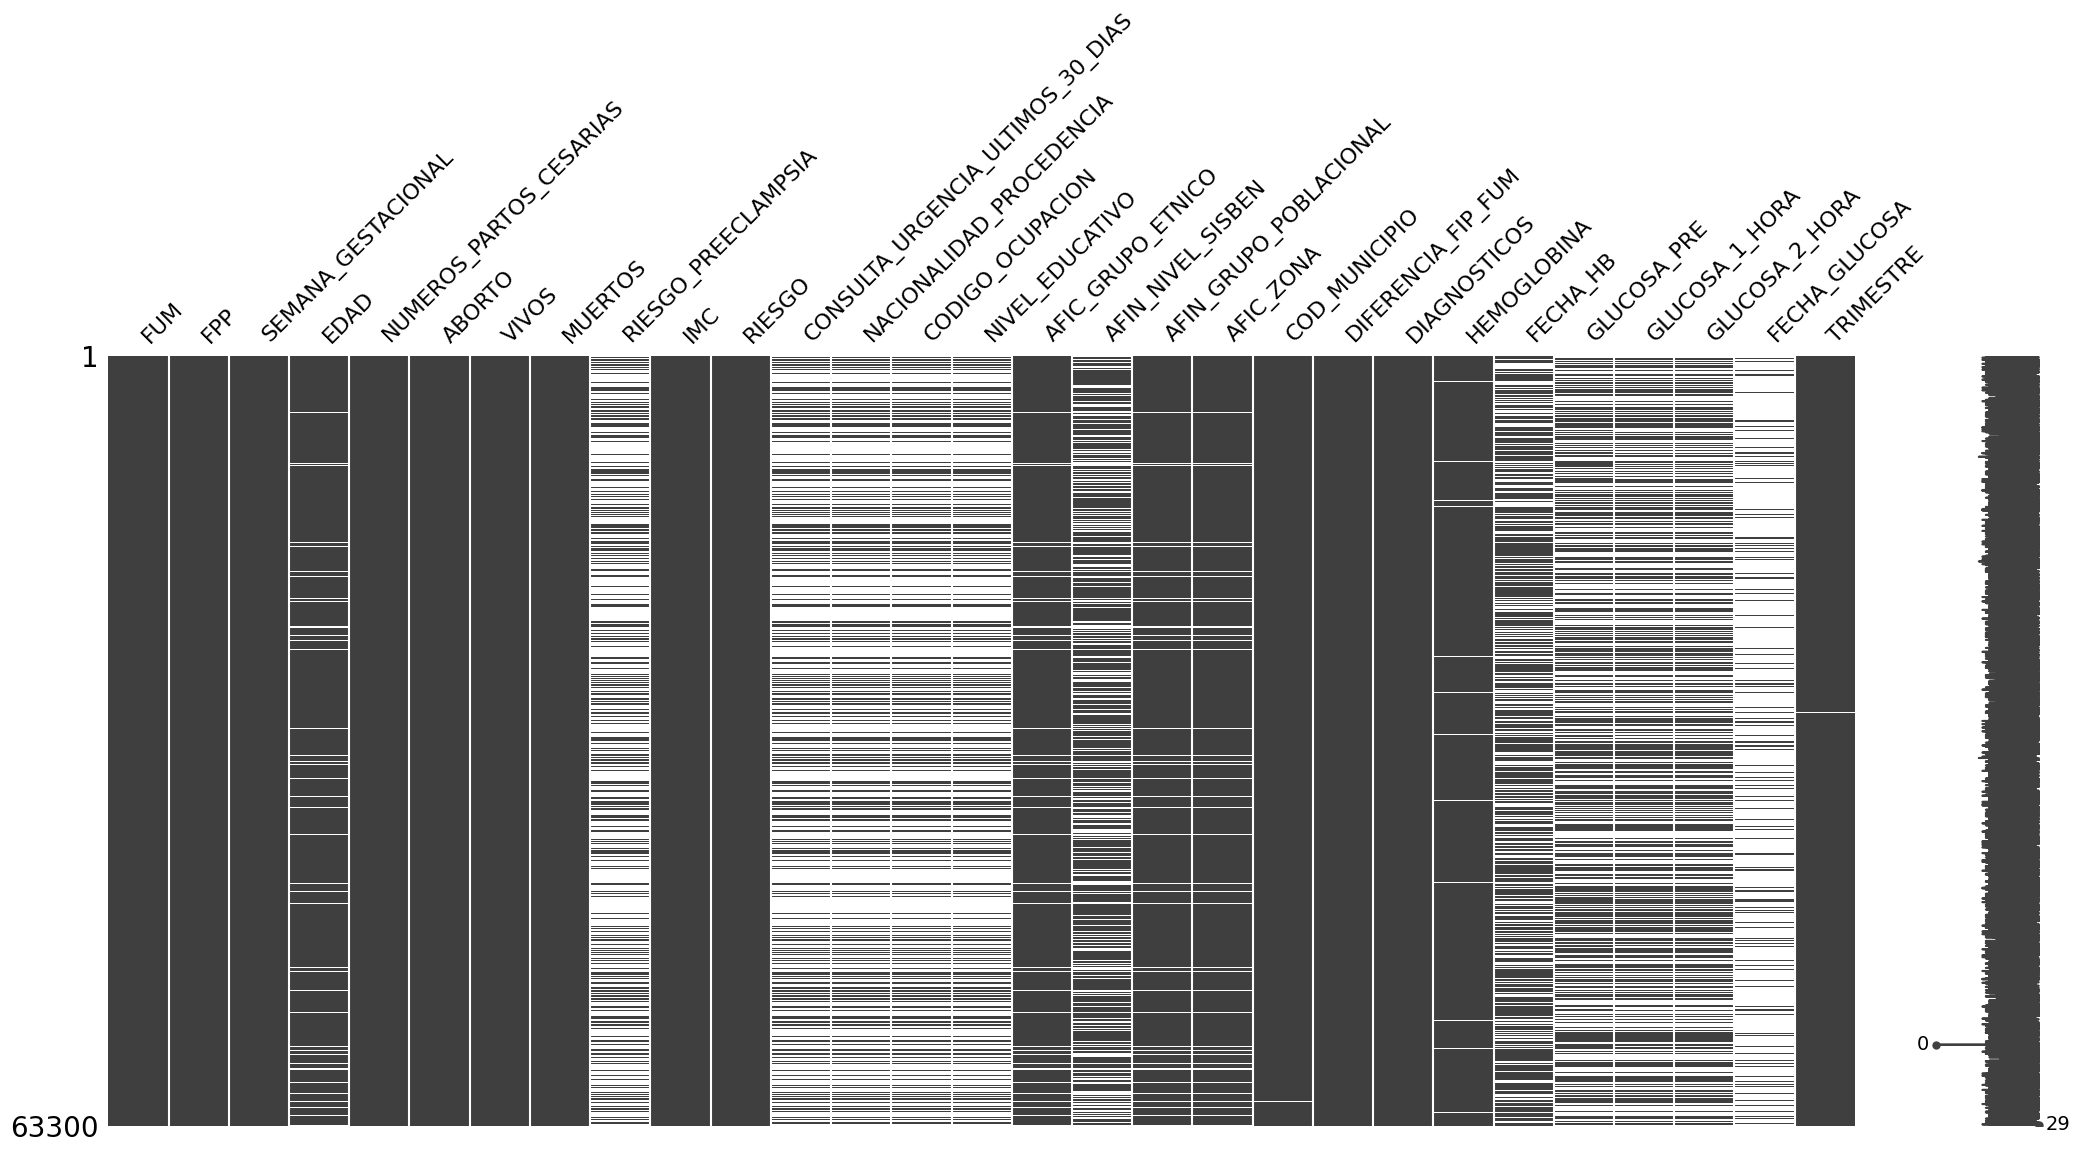

<Figure size 1000x600 with 0 Axes>

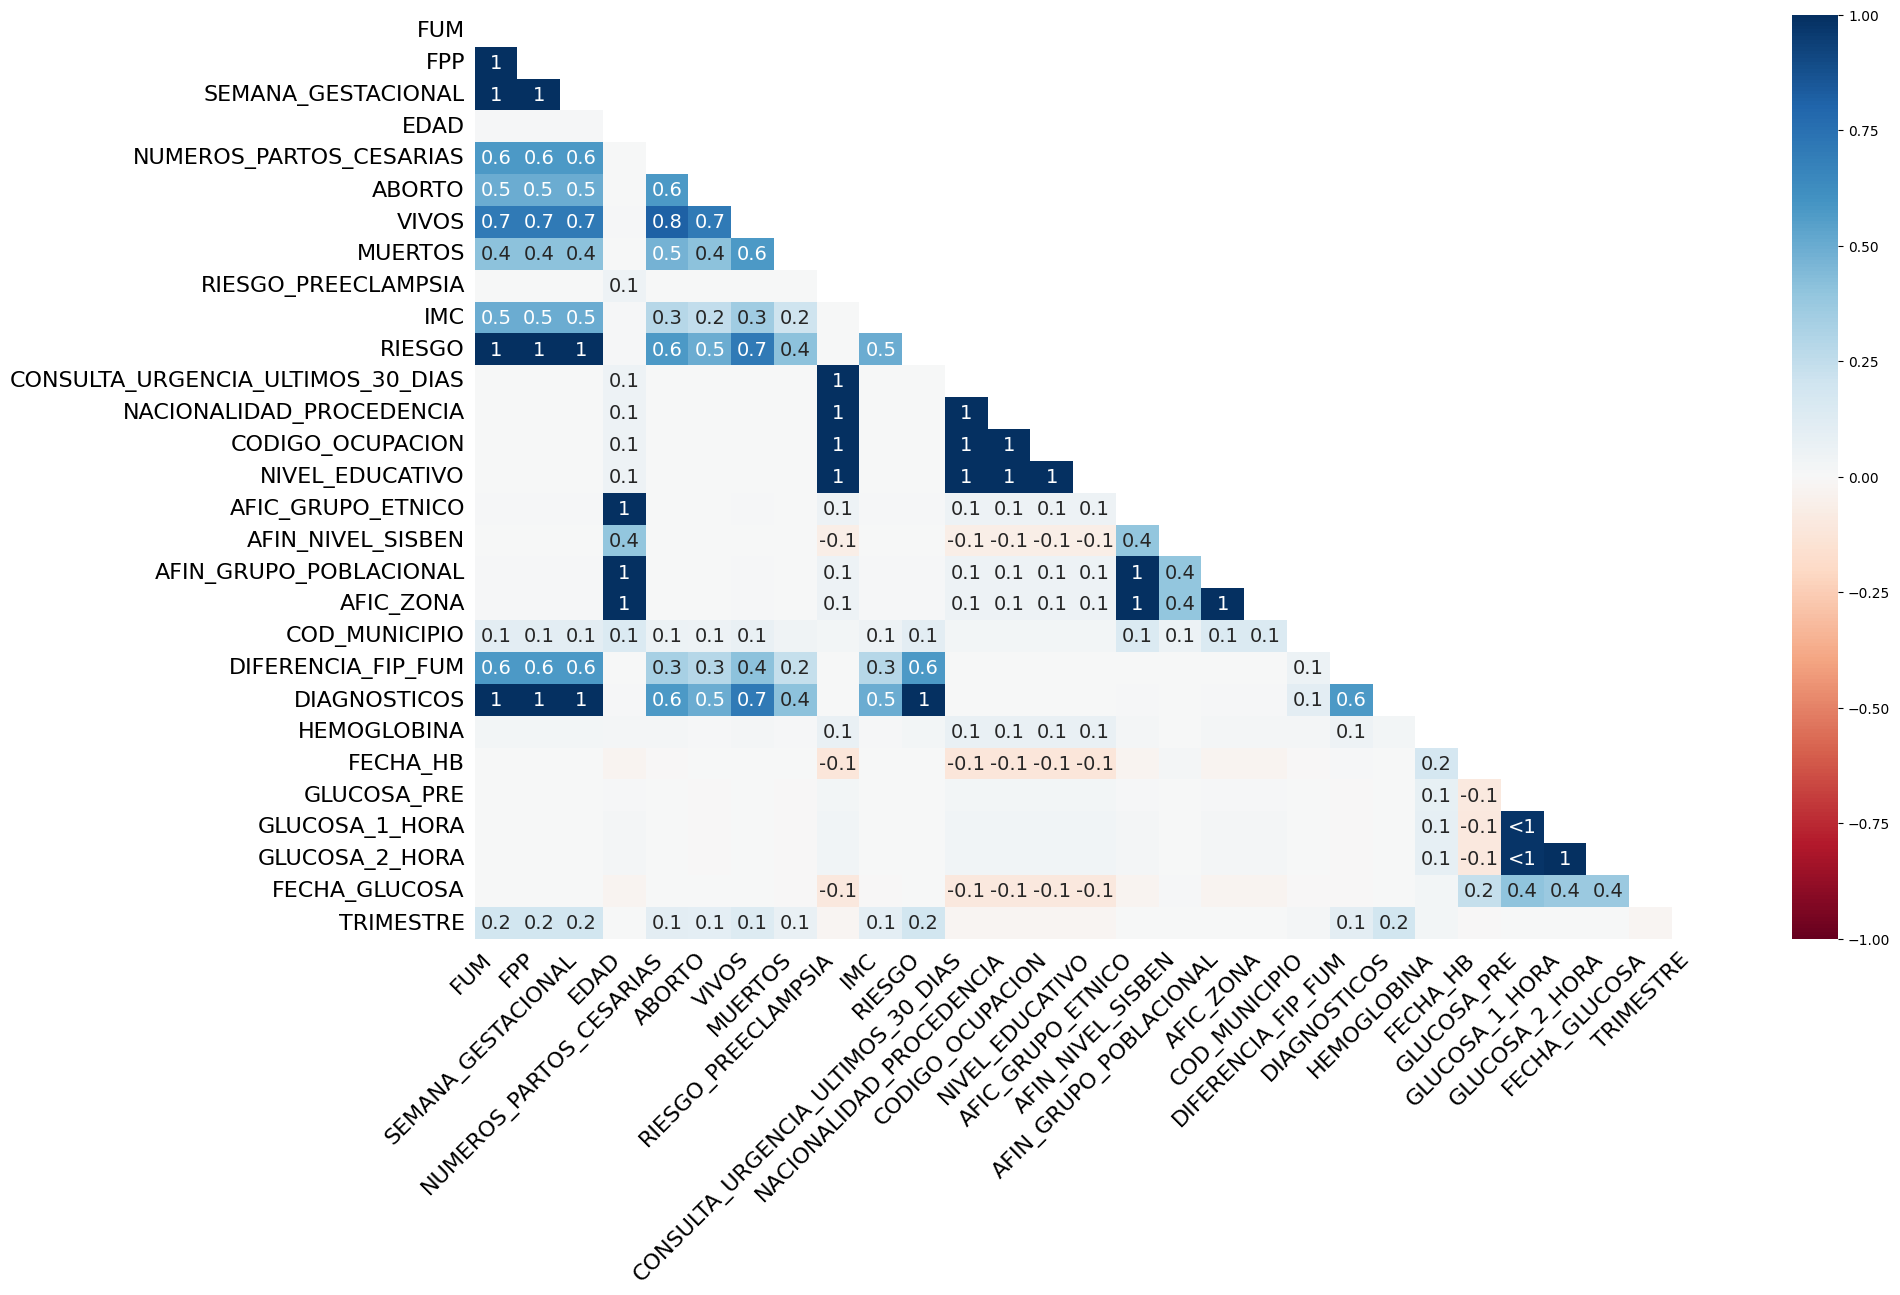

In [ ]:
# Identificar columnas con y sin valores faltantes
missing_data = df_smh.isnull().sum()
no_missing_columns = missing_data[missing_data == 0].index.tolist()
missing_columns = missing_data[missing_data > 0].index.tolist()
missing_columns = missing_columns

# Imprimir la lista de variables que no tienen valores faltantes
print(f"Variables sin valores faltantes: {no_missing_columns}")

# Crear un DataFrame solo con las columnas que tienen datos faltantes
df_missing = df_smh[missing_columns]

# Visualización básica de datos perdidos (solo columnas con datos faltantes)
plt.figure(figsize=(10, 6))
msno.matrix(df_missing)
plt.show()

# Mapa de calor para correlación de datos faltantes
plt.figure(figsize=(10, 6))
msno.heatmap(df_missing)
plt.show()

##### Exploración Univariada - Variables Categóricas

In [ ]:
# Función para resumir frecuencias de variables categóricas en formato tabular
def resumen_frecuencias_categoricas(df, features):
    res = {}

    for feature in features:
        # Calcular conteos y porcentajes
        counts = df[feature].value_counts()
        percentages = df[feature].value_counts(normalize=True) * 100

        # Crear un DataFrame temporal
        temp_df = pd.DataFrame({f'Conteo ({feature})': counts, f'Porcentaje (%) ({feature})': percentages.round(2)})
        res[feature] = temp_df.head(5)

    return res

# Generar resumen para todas las variables categóricas
resumen_categorico = resumen_frecuencias_categoricas(df_smh, categorical_features)

# Mostrar las tablas utilizando Styler
for feature, table in resumen_categorico.items():
    display(table.style.set_caption(f"Frecuencia de {feature}").set_table_styles([{
        'selector': 'caption',
        'props': 'caption-side: top; font-weight: bold; text-align: center; font-size: 16px;'
    }]))

,Conteo (RIESGO_PREECLAMPSIA),Porcentaje (%) (RIESGO_PREECLAMPSIA)
RIESGO_PREECLAMPSIA,,
BAJO,20742,93.470000
ALTO,1450,6.530000


,Conteo (CONSULTA_URGENCIA_ULTIMOS_30_DIAS),Porcentaje (%) (CONSULTA_URGENCIA_ULTIMOS_30_DIAS)
CONSULTA_URGENCIA_ULTIMOS_30_DIAS,,
NO,21992,99.100000
SI,200,0.900000


,Conteo (MAYOR_35),Porcentaje (%) (MAYOR_35)
MAYOR_35,,
0,58325,92.140000
1,4975,7.860000


,Conteo (NACIONALIDAD_PROCEDENCIA),Porcentaje (%) (NACIONALIDAD_PROCEDENCIA)
NACIONALIDAD_PROCEDENCIA,,
170.0,21911,98.730000
862.0,281,1.270000


,Conteo (CODIGO_OCUPACION),Porcentaje (%) (CODIGO_OCUPACION)
CODIGO_OCUPACION,,
9998.0,10579,47.670000
9609.0,6524,29.400000
9999.0,3207,14.450000
9111.0,1287,5.800000
9622.0,392,1.770000


,Conteo (NIVEL_EDUCATIVO),Porcentaje (%) (NIVEL_EDUCATIVO)
NIVEL_EDUCATIVO,,
3.0,13663,61.570000
4.0,4547,20.490000
13.0,2791,12.580000
6.0,335,1.510000
5.0,281,1.270000


,Conteo (AFIC_GRUPO_ETNICO),Porcentaje (%) (AFIC_GRUPO_ETNICO)
AFIC_GRUPO_ETNICO,,
6.0,56997,96.610000
1.0,1524,2.580000
5.0,372,0.630000
3.0,77,0.130000
4.0,27,0.050000


,Conteo (AFIN_NIVEL_SISBEN),Porcentaje (%) (AFIN_NIVEL_SISBEN)
AFIN_NIVEL_SISBEN,,
1.0,40298,93.900000
2.0,2594,6.040000
3.0,24,0.060000


,Conteo (AFIN_GRUPO_POBLACIONAL),Porcentaje (%) (AFIN_GRUPO_POBLACIONAL)
AFIN_GRUPO_POBLACIONAL,,
5.0,42928,72.760000
9.0,14283,24.210000
31.0,686,1.160000
17.0,518,0.880000
0.0,293,0.500000


,Conteo (AFIC_ZONA),Porcentaje (%) (AFIC_ZONA)
AFIC_ZONA,,
U,37409,63.410000
R,21587,36.590000


,Conteo (COD_MUNICIPIO),Porcentaje (%) (COD_MUNICIPIO)
COD_MUNICIPIO,,
8001.0,5585,8.840000
13001.0,4958,7.840000
23001.0,3728,5.900000
8758.0,2358,3.730000
70001.0,2351,3.720000


,Conteo (DIAGNOSTICOS),Porcentaje (%) (DIAGNOSTICOS)
DIAGNOSTICOS,,
Z359,13565,21.430000
Z321,8875,14.020000
Z321 Z321 Z321 Z321 Z321 Z321 Z321,3075,4.860000
Z359 Z321 Z358,2725,4.300000
Z321 Z348,2673,4.220000


,Conteo (TRIMESTRE),Porcentaje (%) (TRIMESTRE)
TRIMESTRE,,
PRIMER_TRIMESTRE,23081,36.480000
SEGUNDO_TRIMESTRE,21924,34.650000
TERCER_TRIMESTRE,18267,28.870000


,Conteo (ETIQUETA_MORBILIDAD),Porcentaje (%) (ETIQUETA_MORBILIDAD)
ETIQUETA_MORBILIDAD,,
0,60481,95.550000
1,2819,4.450000


,Conteo (HIPERTENSION),Porcentaje (%) (HIPERTENSION)
HIPERTENSION,,
NO,62928,99.410000
SI,372,0.590000


,Conteo (VIH_MATERNO_CONFIRMADO),Porcentaje (%) (VIH_MATERNO_CONFIRMADO)
VIH_MATERNO_CONFIRMADO,,
NO,63236,99.900000
SI,64,0.100000


,Conteo (TAMIZAJE_SIFILIS),Porcentaje (%) (TAMIZAJE_SIFILIS)
TAMIZAJE_SIFILIS,,
SI,47977,75.790000
NO,15323,24.210000


,Conteo (TAMIZAJE_VIH),Porcentaje (%) (TAMIZAJE_VIH)
TAMIZAJE_VIH,,
SI,49885,78.810000
NO,13415,21.190000


,Conteo (TAMIZAJE_HEPATITIS),Porcentaje (%) (TAMIZAJE_HEPATITIS)
TAMIZAJE_HEPATITIS,,
SI,62132,98.150000
NO,1168,1.850000


,Conteo (HEMORRAGIA),Porcentaje (%) (HEMORRAGIA)
HEMORRAGIA,,
NO,63298,100.000000
SI,2,0.000000


,Conteo (POLIHIDRAMNIOS),Porcentaje (%) (POLIHIDRAMNIOS)
POLIHIDRAMNIOS,,
NO,63298,100.000000
SI,2,0.000000


,Conteo (MORTALIDAD_PERINATAL_NEONATAL_TARDIA_PREVIA),Porcentaje (%) (MORTALIDAD_PERINATAL_NEONATAL_TARDIA_PREVIA)
MORTALIDAD_PERINATAL_NEONATAL_TARDIA_PREVIA,,
0,63100,99.680000
1,200,0.320000


##### Exploración Univariada - Variables Numéricas

<ipython-input-12-8362e73c192a>:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


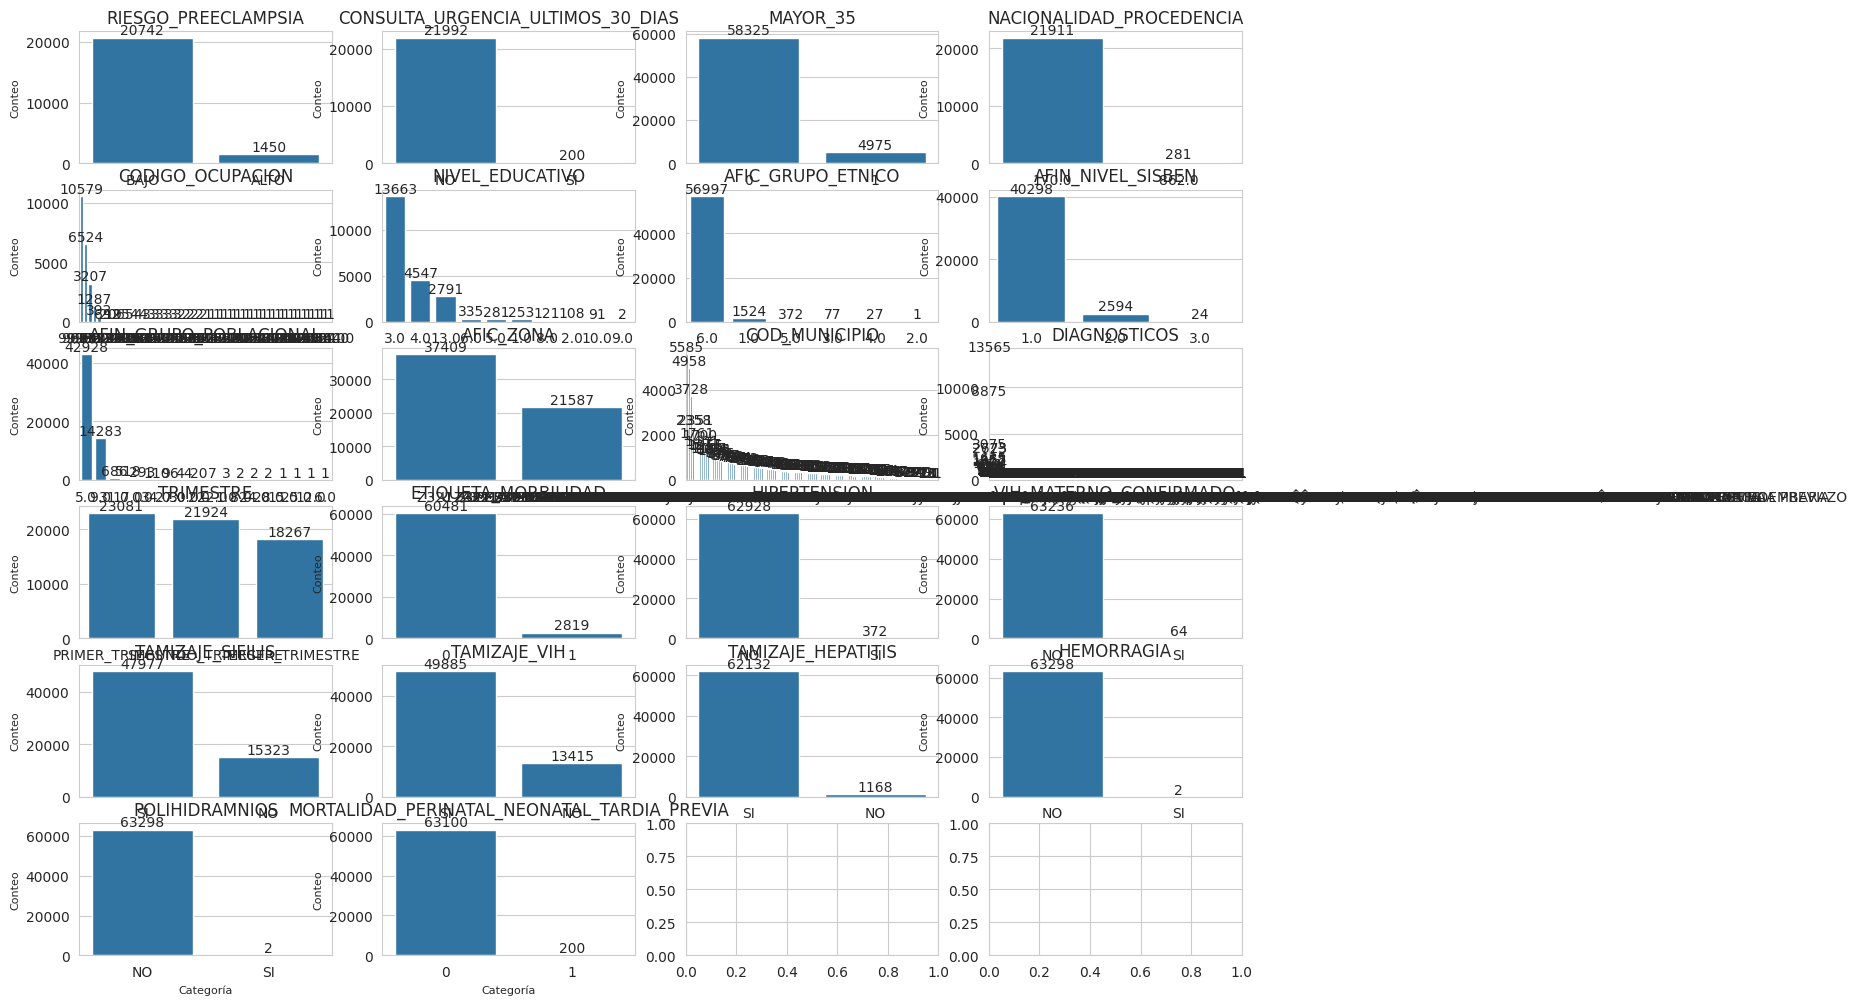

In [ ]:
# Configurar el estilo de las gráficas
sns.set_style('whitegrid')

# Crear un arreglo de subplots
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 12))
axes = axes.flatten()

# Iterar sobre las variables categóricas
for i, feature in enumerate(categorical_features):
    # Obtener los conteos de cada categoría
    counts = df_smh[feature].value_counts()

    # Crear una gráfica de barras
    sns.barplot(x=counts.index, y=counts.values, ax=axes[i])

    # Configurar la gráfica
    axes[i].set_title(feature, fontsize=12)
    axes[i].set_xlabel('Categoría', fontsize=8)
    axes[i].set_ylabel('Conteo', fontsize=8)
    axes[i].bar_label(axes[i].containers[0])

# Ajustar el espaciado y mostrar la gráfica
plt.tight_layout()
plt.show()

Análisis de asociación

In [ ]:
# Crear un LabelEncoder para las variables categóricas
label_encoders = {}
for feature in categorical_features:
    if feature in df_smh.columns:
        le = LabelEncoder()
        df_smh[feature] = le.fit_transform(df_smh[feature].astype(str))
        label_encoders[feature] = le

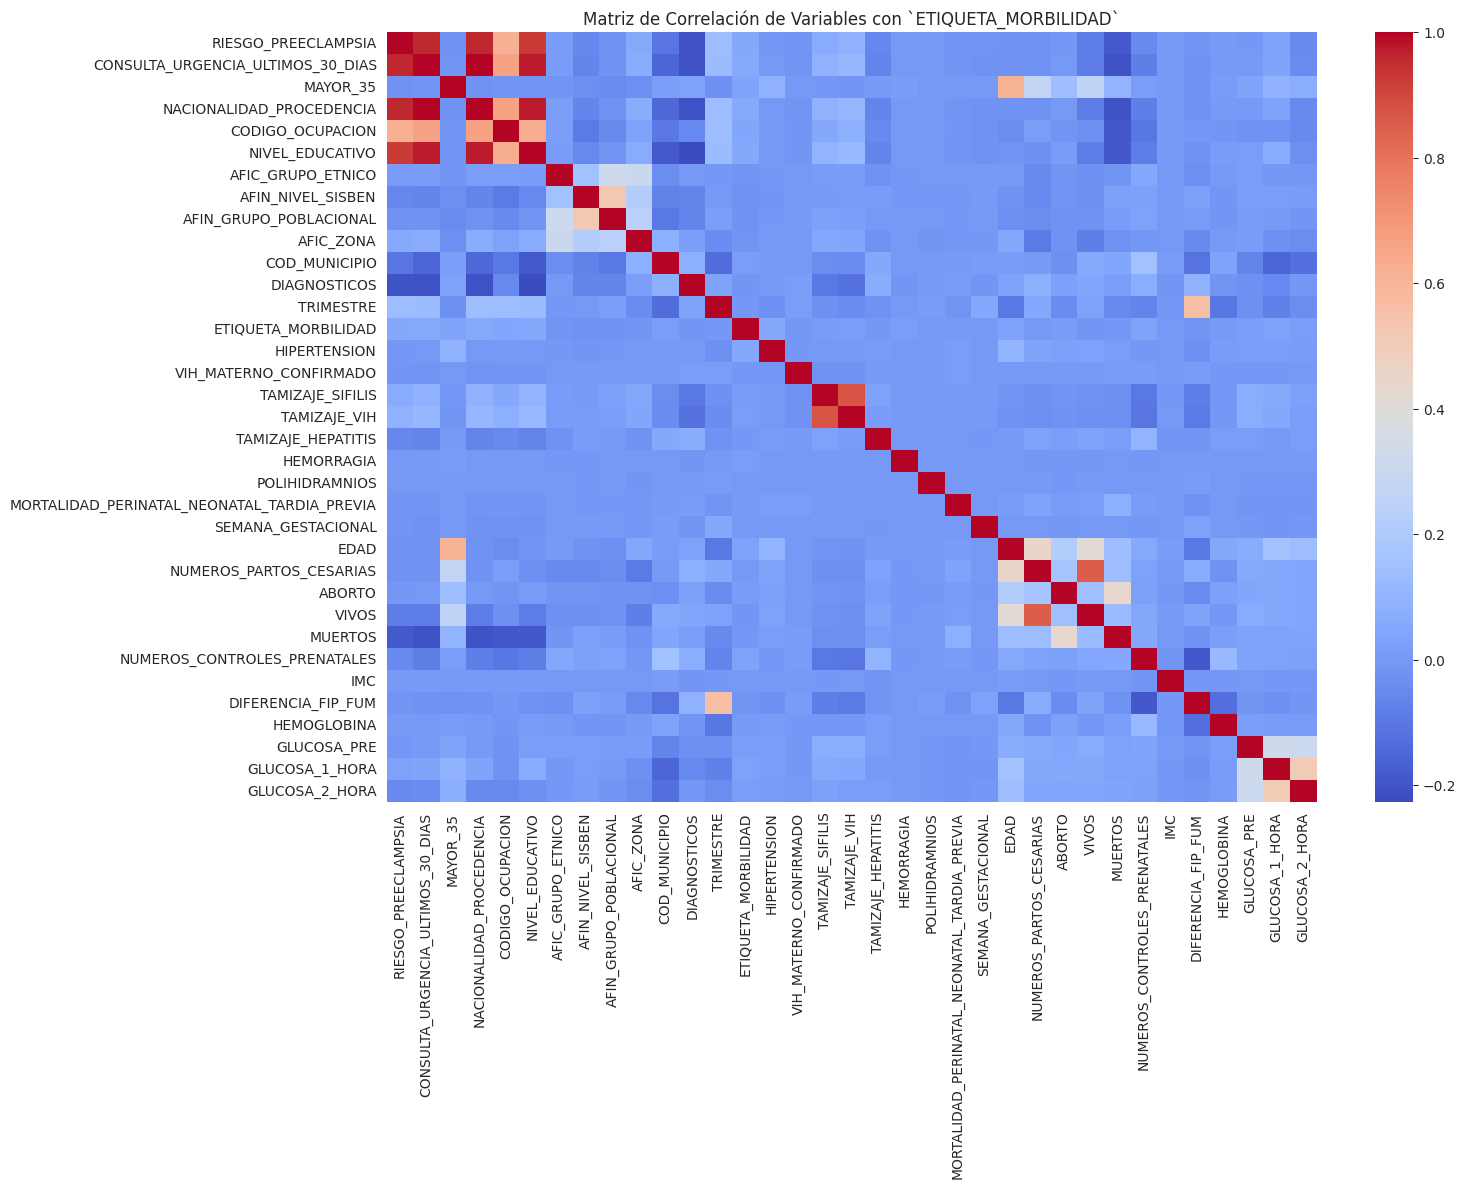

In [ ]:
# Filtrar solo las columnas que están en los conjuntos categóricos y numéricos
all_features = categorical_features + numerical_features

# Crear una nueva matriz de características con solo las columnas relevantes
correlation_matrix = df_smh[all_features].corr()

# Mostrar el mapa de calor de correlaciones
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix,cmap='coolwarm') #, fmt=".1f" ,  annot=True,
plt.title("Matriz de Correlación de Variables con `ETIQUETA_MORBILIDAD`")
plt.show()

In [ ]:
# Mostrar correlación individual de cada característica con `ETIQUETA_MORBILIDAD`
correlation_with_target = correlation_matrix['ETIQUETA_MORBILIDAD'].sort_values(ascending=False)
print("Correlación de Variables con `ETIQUETA_MORBILIDAD`:\n", correlation_with_target)

Correlación de Variables con `ETIQUETA_MORBILIDAD`:
 ETIQUETA_MORBILIDAD                            1.000000
CONSULTA_URGENCIA_ULTIMOS_30_DIAS              0.056791
NACIONALIDAD_PROCEDENCIA                       0.056162
RIESGO_PREECLAMPSIA                            0.053840
HIPERTENSION                                   0.053538
NIVEL_EDUCATIVO                                0.051725
CODIGO_OCUPACION                               0.041215
MAYOR_35                                       0.038546
NUMEROS_CONTROLES_PRENATALES                   0.031893
EDAD                                           0.030051
GLUCOSA_1_HORA                                 0.027181
GLUCOSA_2_HORA                                 0.016027
GLUCOSA_PRE                                    0.014857
TAMIZAJE_VIH                                   0.012822
COD_MUNICIPIO                                  0.012718
HEMORRAGIA                                     0.012411
TAMIZAJE_SIFILIS                               0.01

<ipython-input-16-aad480eee692>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='coolwarm')


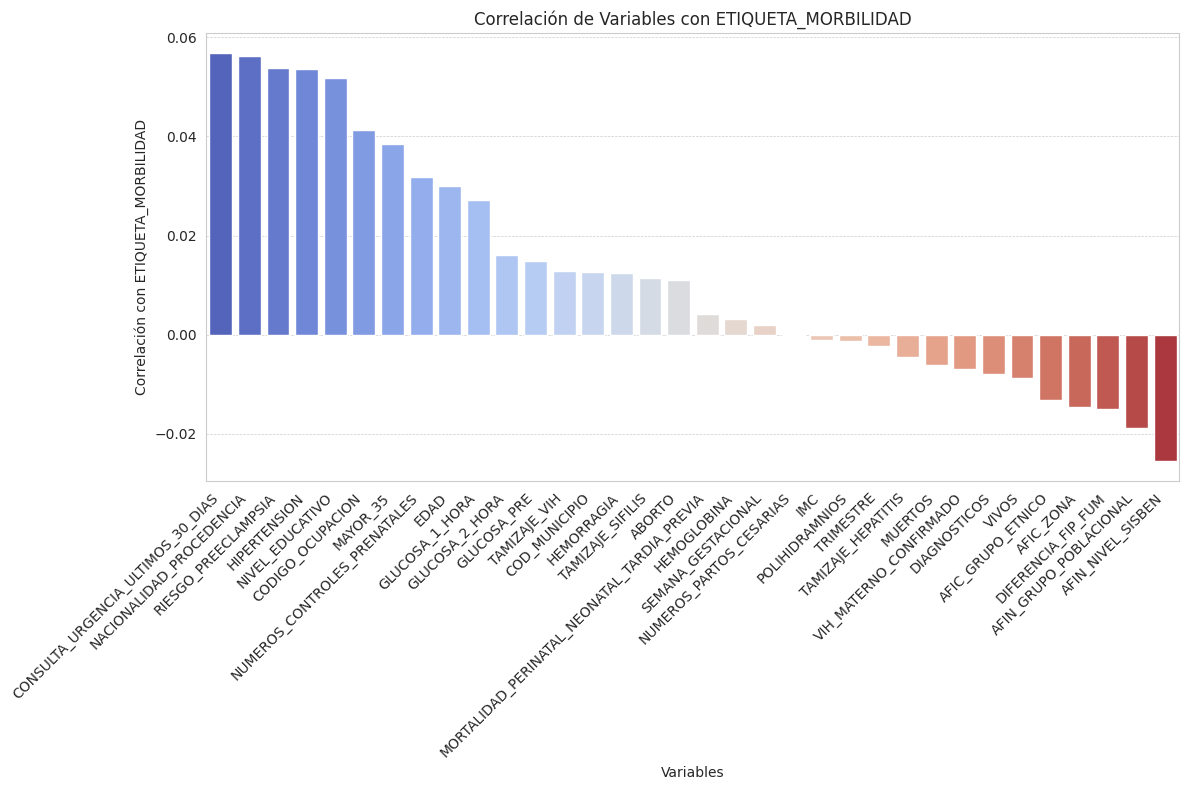

In [ ]:
# Correlación individual de cada característica con `ETIQUETA_MORBILIDAD`, excluyendo `ETIQUETA_MORBILIDAD`
correlation_with_target = correlation_matrix['ETIQUETA_MORBILIDAD'].drop('ETIQUETA_MORBILIDAD').sort_values(ascending=False)

# Gráfico con seaborn (Mapa de Calor)
plt.figure(figsize=(12, 8))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Variables')
plt.ylabel('Correlación con ETIQUETA_MORBILIDAD')
plt.title('Correlación de Variables con ETIQUETA_MORBILIDAD')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
def chi2_test(df, col_target, col_feature):
    contingency_table = pd.crosstab(df[col_target], df[col_feature])
    _, p, _, _ = chi2_contingency(contingency_table)
    return p

# Crear un DataFrame para mostrar los resultados de la asociación
chi2_results = {}

for feature in categorical_features:
    if feature in df_smh.columns:
        p_value = chi2_test(df_smh, 'ETIQUETA_MORBILIDAD', feature)
        chi2_results[feature] = p_value

chi2_results = pd.Series(chi2_results).sort_values()
print("Resultados de Asociación Chi-cuadrado con `ETIQUETA_MORBILIDAD`:\n", chi2_results)

Resultados de Asociación Chi-cuadrado con `ETIQUETA_MORBILIDAD`:
 ETIQUETA_MORBILIDAD                            0.000000e+00
NIVEL_EDUCATIVO                                2.569042e-46
CONSULTA_URGENCIA_ULTIMOS_30_DIAS              1.956376e-45
RIESGO_PREECLAMPSIA                            1.900615e-44
NACIONALIDAD_PROCEDENCIA                       1.902447e-44
COD_MUNICIPIO                                  7.812995e-43
HIPERTENSION                                   1.284569e-40
DIAGNOSTICOS                                   4.257931e-27
MAYOR_35                                       4.363284e-22
AFIC_ZONA                                      6.092820e-19
CODIGO_OCUPACION                               9.703015e-19
AFIC_GRUPO_ETNICO                              2.653898e-16
AFIN_GRUPO_POBLACIONAL                         2.483888e-13
AFIN_NIVEL_SISBEN                              3.780698e-10
TAMIZAJE_VIH                                   1.362513e-03
TAMIZAJE_SIFILIS                  

# Resumen y Recomendaciones

**Variables Significativas:**
- Tienen un valor p bajo (menor a 0.05), indicando una relación estadísticamente significativa con `ETIQUETA_MORBILIDAD`.
- Ejemplos: **`NIVEL_EDUCATIVO`**, **`CONSULTA_URGENCIA_ULTIMOS_30_DIAS`** y **`RIESGO_PREECLAMPSIA`**.

**Variables No Significativas:**
- Tienen un valor p alto, lo que sugiere que no hay evidencia suficiente para demostrar una asociación con `ETIQUETA_MORBILIDAD`.

**Conclusión General:**
- Las variables con valores p bajos deben ser consideradas para un modelo predictivo, ya que tienen una relación significativa con `ETIQUETA_MORBILIDAD`.

## Pasos Futuros

1. **Análisis de Características Significativas:**
   - Profundizar el análisis de las variables significativamente asociadas con `ETIQUETA_MORBILIDAD`.

2. **Construir un Modelo Predictivo:**
   - Utilizar las variables más significativas para crear un modelo predictivo.

3. **Evaluar el Modelo:**
   - Evaluar el modelo utilizando técnicas como validación cruzada y métricas adecuadas.


## Exploracion variables Numéricas

In [ ]:
df_smh.head(1)

,FUM,FPP,SEMANA_GESTACIONAL,EDAD,MAYOR_35,NUMEROS_PARTOS_CESARIAS,ABORTO,VIVOS,MUERTOS,RIESGO_PREECLAMPSIA,NUMEROS_CONTROLES_PRENATALES,IMC,RIESGO,CONSULTA_URGENCIA_ULTIMOS_30_DIAS,NACIONALIDAD_PROCEDENCIA,CODIGO_OCUPACION,NIVEL_EDUCATIVO,AFIC_GRUPO_ETNICO,AFIN_NIVEL_SISBEN,AFIN_GRUPO_POBLACIONAL,AFIC_ZONA,COD_MUNICIPIO,DIFERENCIA_FIP_FUM,HIPERTENSION,VIH_MATERNO_CONFIRMADO,TAMIZAJE_SIFILIS,TAMIZAJE_VIH,TAMIZAJE_HEPATITIS,DIAGNOSTICOS,HEMOGLOBINA,FECHA_HB,GLUCOSA_PRE,GLUCOSA_1_HORA,GLUCOSA_2_HORA,FECHA_GLUCOSA,HEMORRAGIA,POLIHIDRAMNIOS,MORTALIDAD_PERINATAL_NEONATAL_TARDIA_PREVIA,TRIMESTRE,ETIQUETA_MORBILIDAD
id_pac,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CC1131479215,2021-08-20 00:00:00,2022-06-01 00:00:00,7.0,19.0,0,0.0,0.0,0.0,0.0,2,6,17.577069,BAJO,2,2,58,10,5,3,17,0,3,52.0,0,0,1,1,1,658,12.0,2021-09-29 00:00:00,52.0,70.0,55.0,NaT,0,0,0,0,0


In [ ]:
df_smh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63300 entries, CC1131479215 to CC1007640655
Data columns (total 40 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   FUM                                          63299 non-null  object 
 1   FPP                                          63299 non-null  object 
 2   SEMANA_GESTACIONAL                           63299 non-null  float64
 3   EDAD                                         58998 non-null  float64
 4   MAYOR_35                                     63300 non-null  int64  
 5   NUMEROS_PARTOS_CESARIAS                      63297 non-null  float64
 6   ABORTO                                       63296 non-null  object 
 7   VIVOS                                        63298 non-null  object 
 8   MUERTOS                                      63294 non-null  object 
 9   RIESGO_PREECLAMPSIA                          63300 non-null

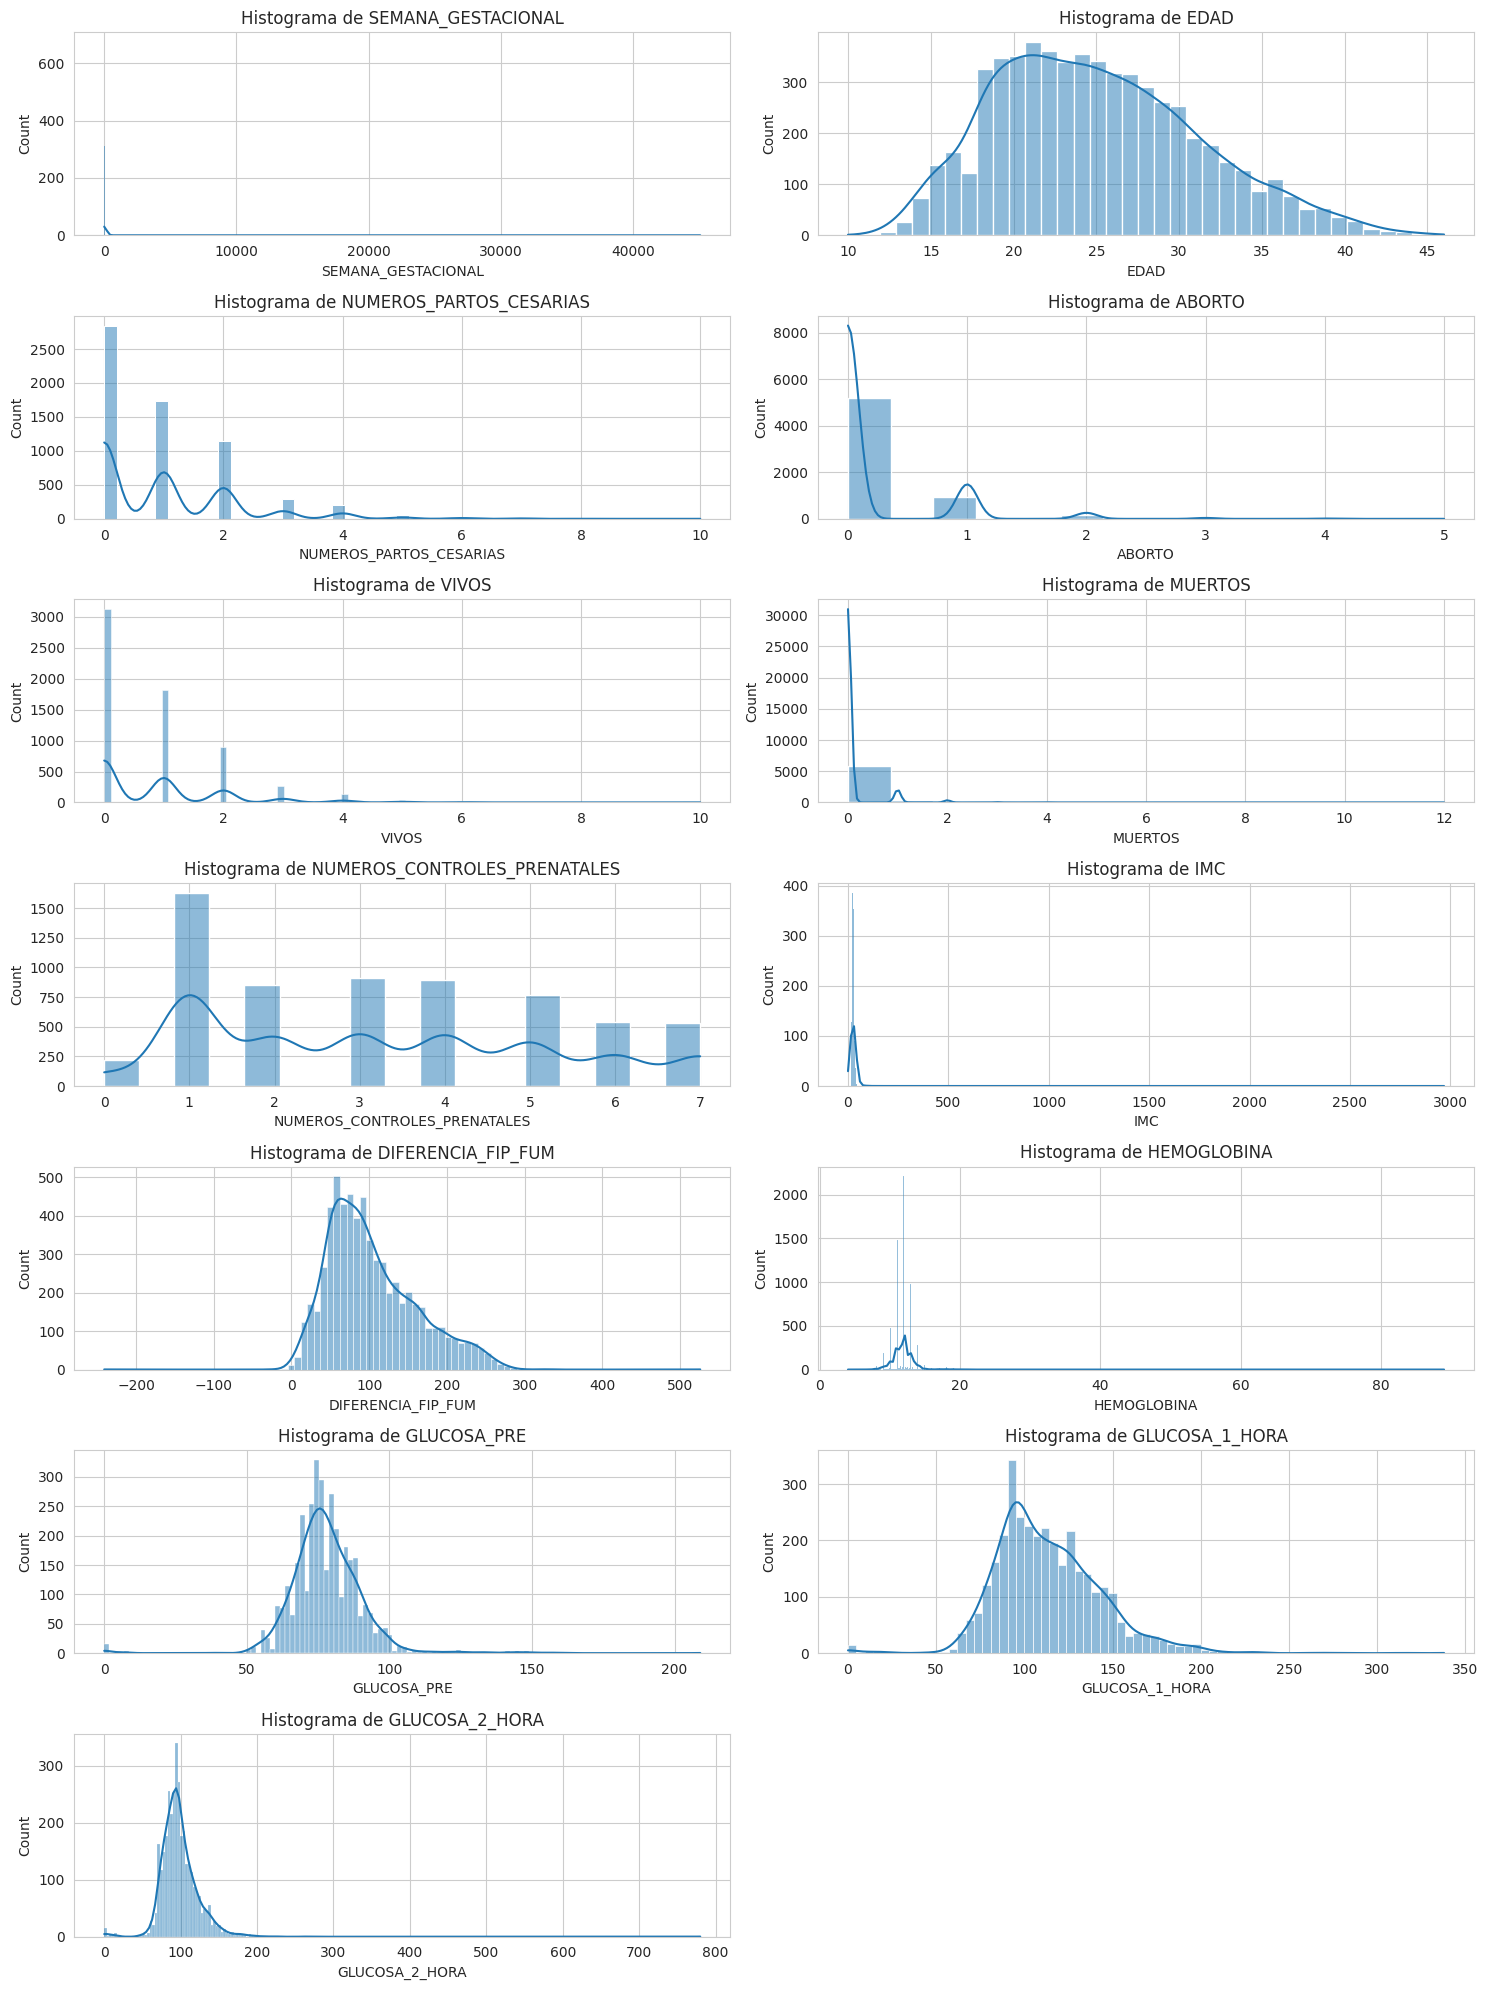

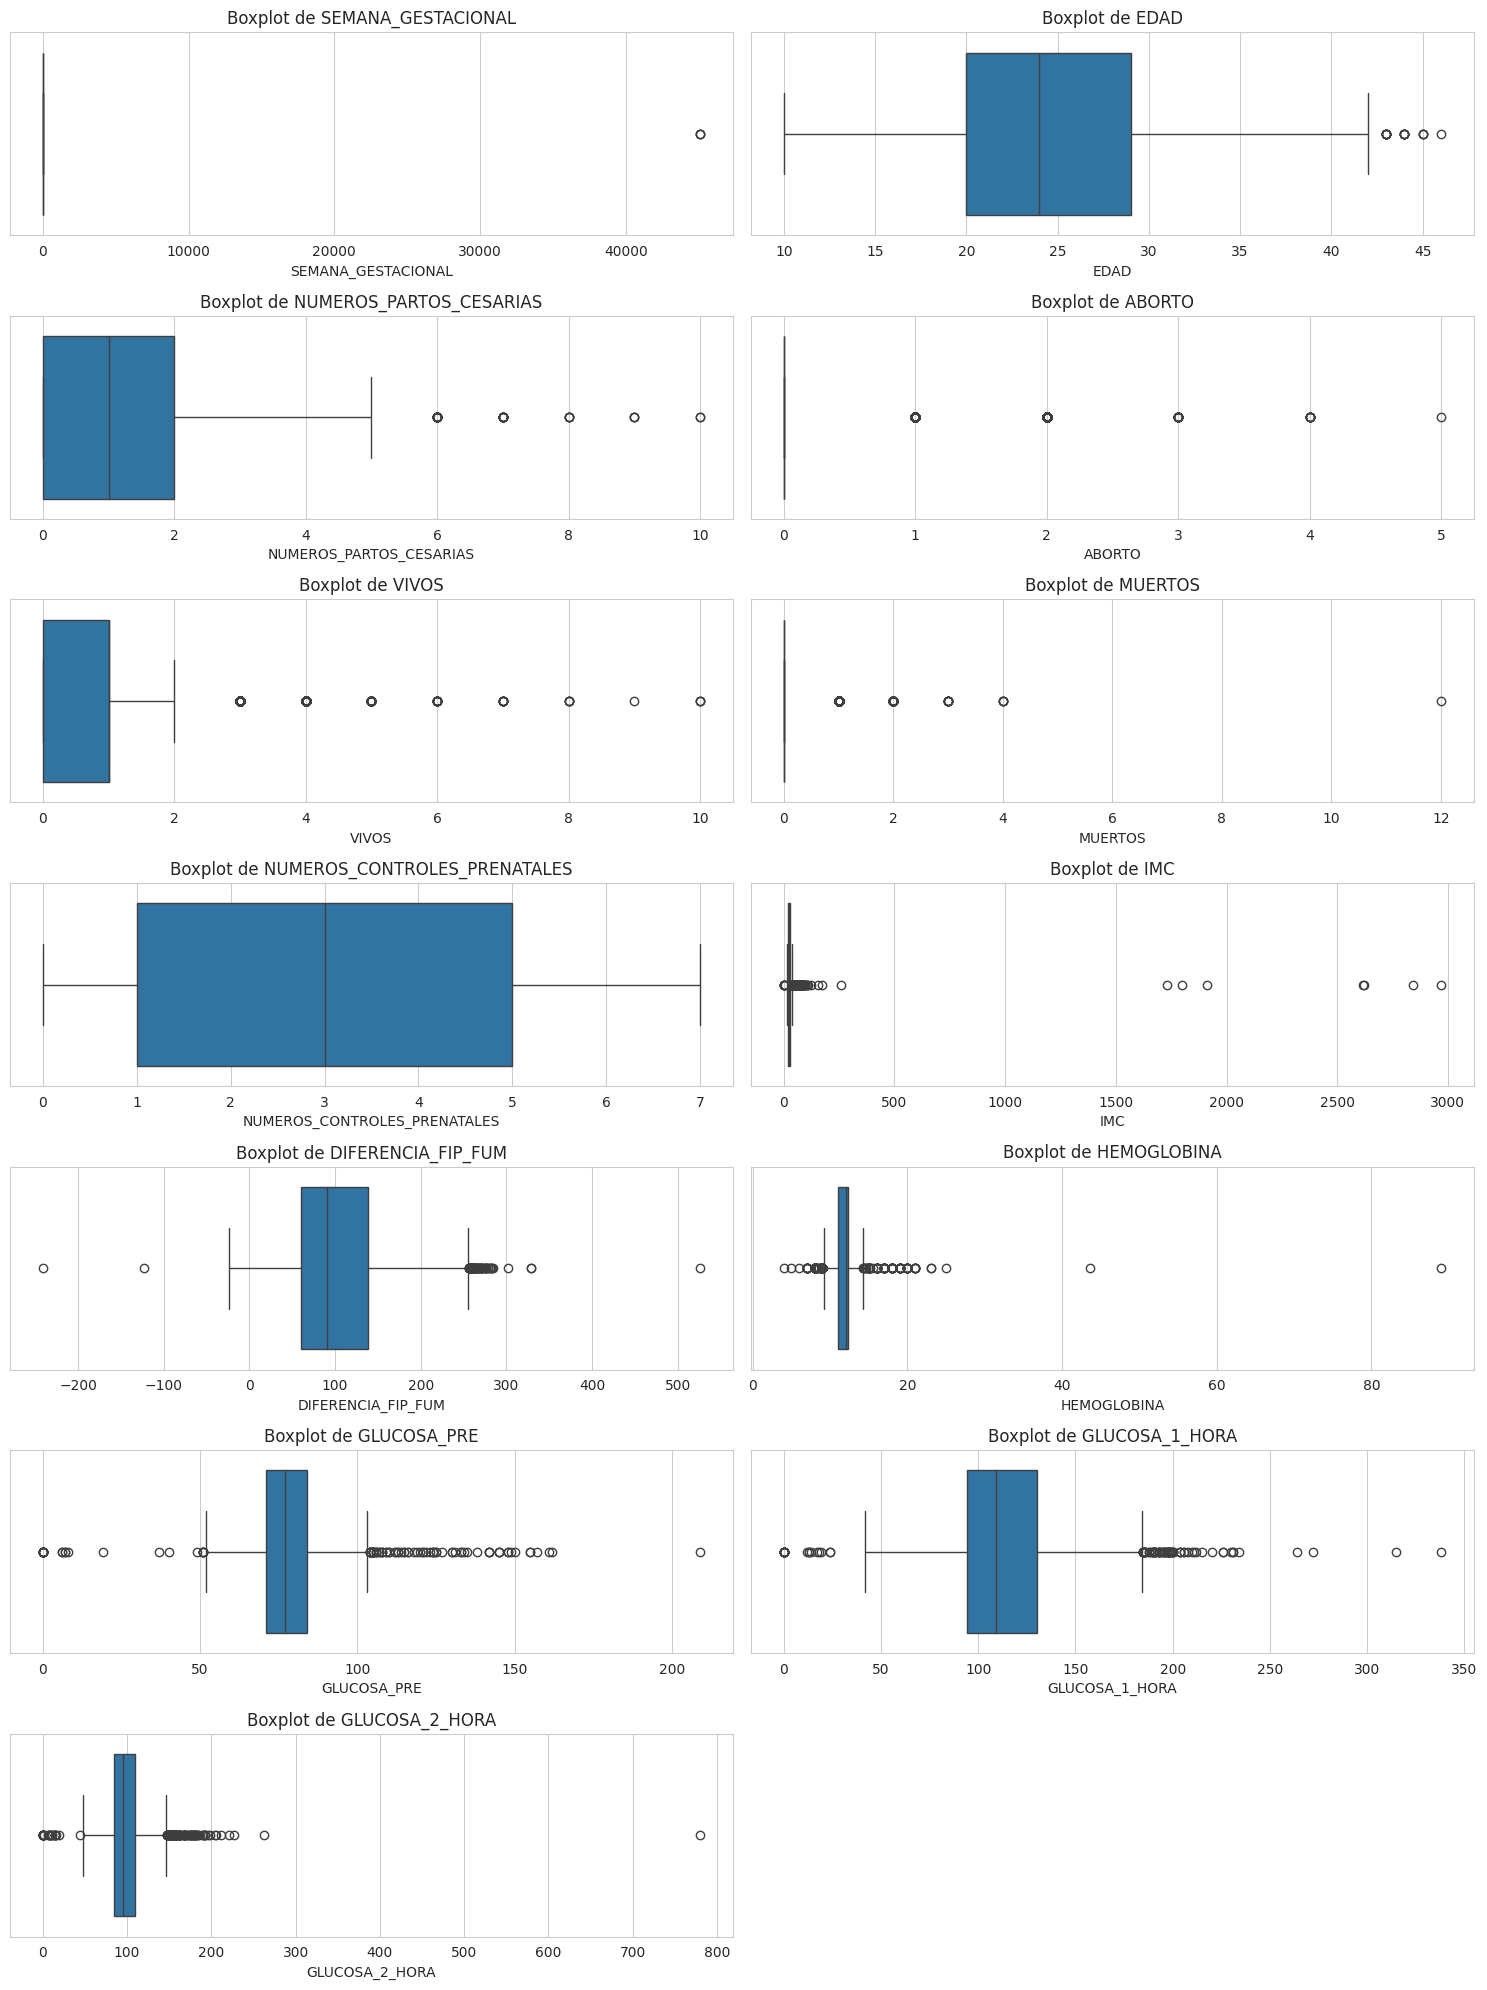

In [ ]:
# Tomar una muestra del 10% de los datos
df_sample = df_smh.sample(frac=0.1, random_state=42)

# Crear histogramas y boxplots utilizando la muestra
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de los gráficos
plt.figure(figsize=(15, 20))

# Histograms
for i, var in enumerate(numerical_features):
    plt.subplot(7, 2, i+1)
    sns.histplot(df_sample[var], kde=True)
    plt.title(f'Histograma de {var}')

plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(15, 20))

for i, var in enumerate(numerical_features):
    plt.subplot(7, 2, i+1)
    sns.boxplot(x=df_sample[var])
    plt.title(f'Boxplot de {var}')

plt.tight_layout()
plt.show()

In [ ]:
def filtrar_datos(df, criterios):
    """
    Filtra el DataFrame basado en criterios de mínimos y máximos para cada variable.

    :param df: DataFrame a filtrar.
    :param criterios: Diccionario con los nombres de las columnas como claves y un
                      tuple (min, max) como valores.
    :return: DataFrame filtrado.
    """
    df_filtrado = df.copy()
    for variable, (min_val, max_val) in criterios.items():
        if variable in df_filtrado.columns:
            df_filtrado = df_filtrado[(df_filtrado[variable] >= min_val) & (df_filtrado[variable] <= max_val)]
    return df_filtrado

# Definir los criterios de filtrado
criterios = {
    'SEMANA_GESTACIONAL': (0, 40),  # Valores ficticios, ajusta según tu caso
    'EDAD': (18, 35),
    #'NUMEROS_PARTOS_CESARIAS': (0, 3),
    #'ABORTO': (0, 2),
    #'VIVOS': (0, 4),
    #'MUERTOS': (0, 1),
    #'NUMEROS_CONTROLES_PRENATALES': (1, 10),
    'IMC': (15, 35),
    #'DIFERENCIA_FIP_FUM': (60, 180),
    #'HEMOGLOBINA': (10, 15),
    #'GLUCOSA_PRE': (70, 110),
    #'GLUCOSA_1_HORA': (90, 180),
    #'GLUCOSA_2_HORA': (90, 160)
}

# Filtrar el DataFrame basado en los criterios
df_filtrado = filtrar_datos(df_smh, criterios)

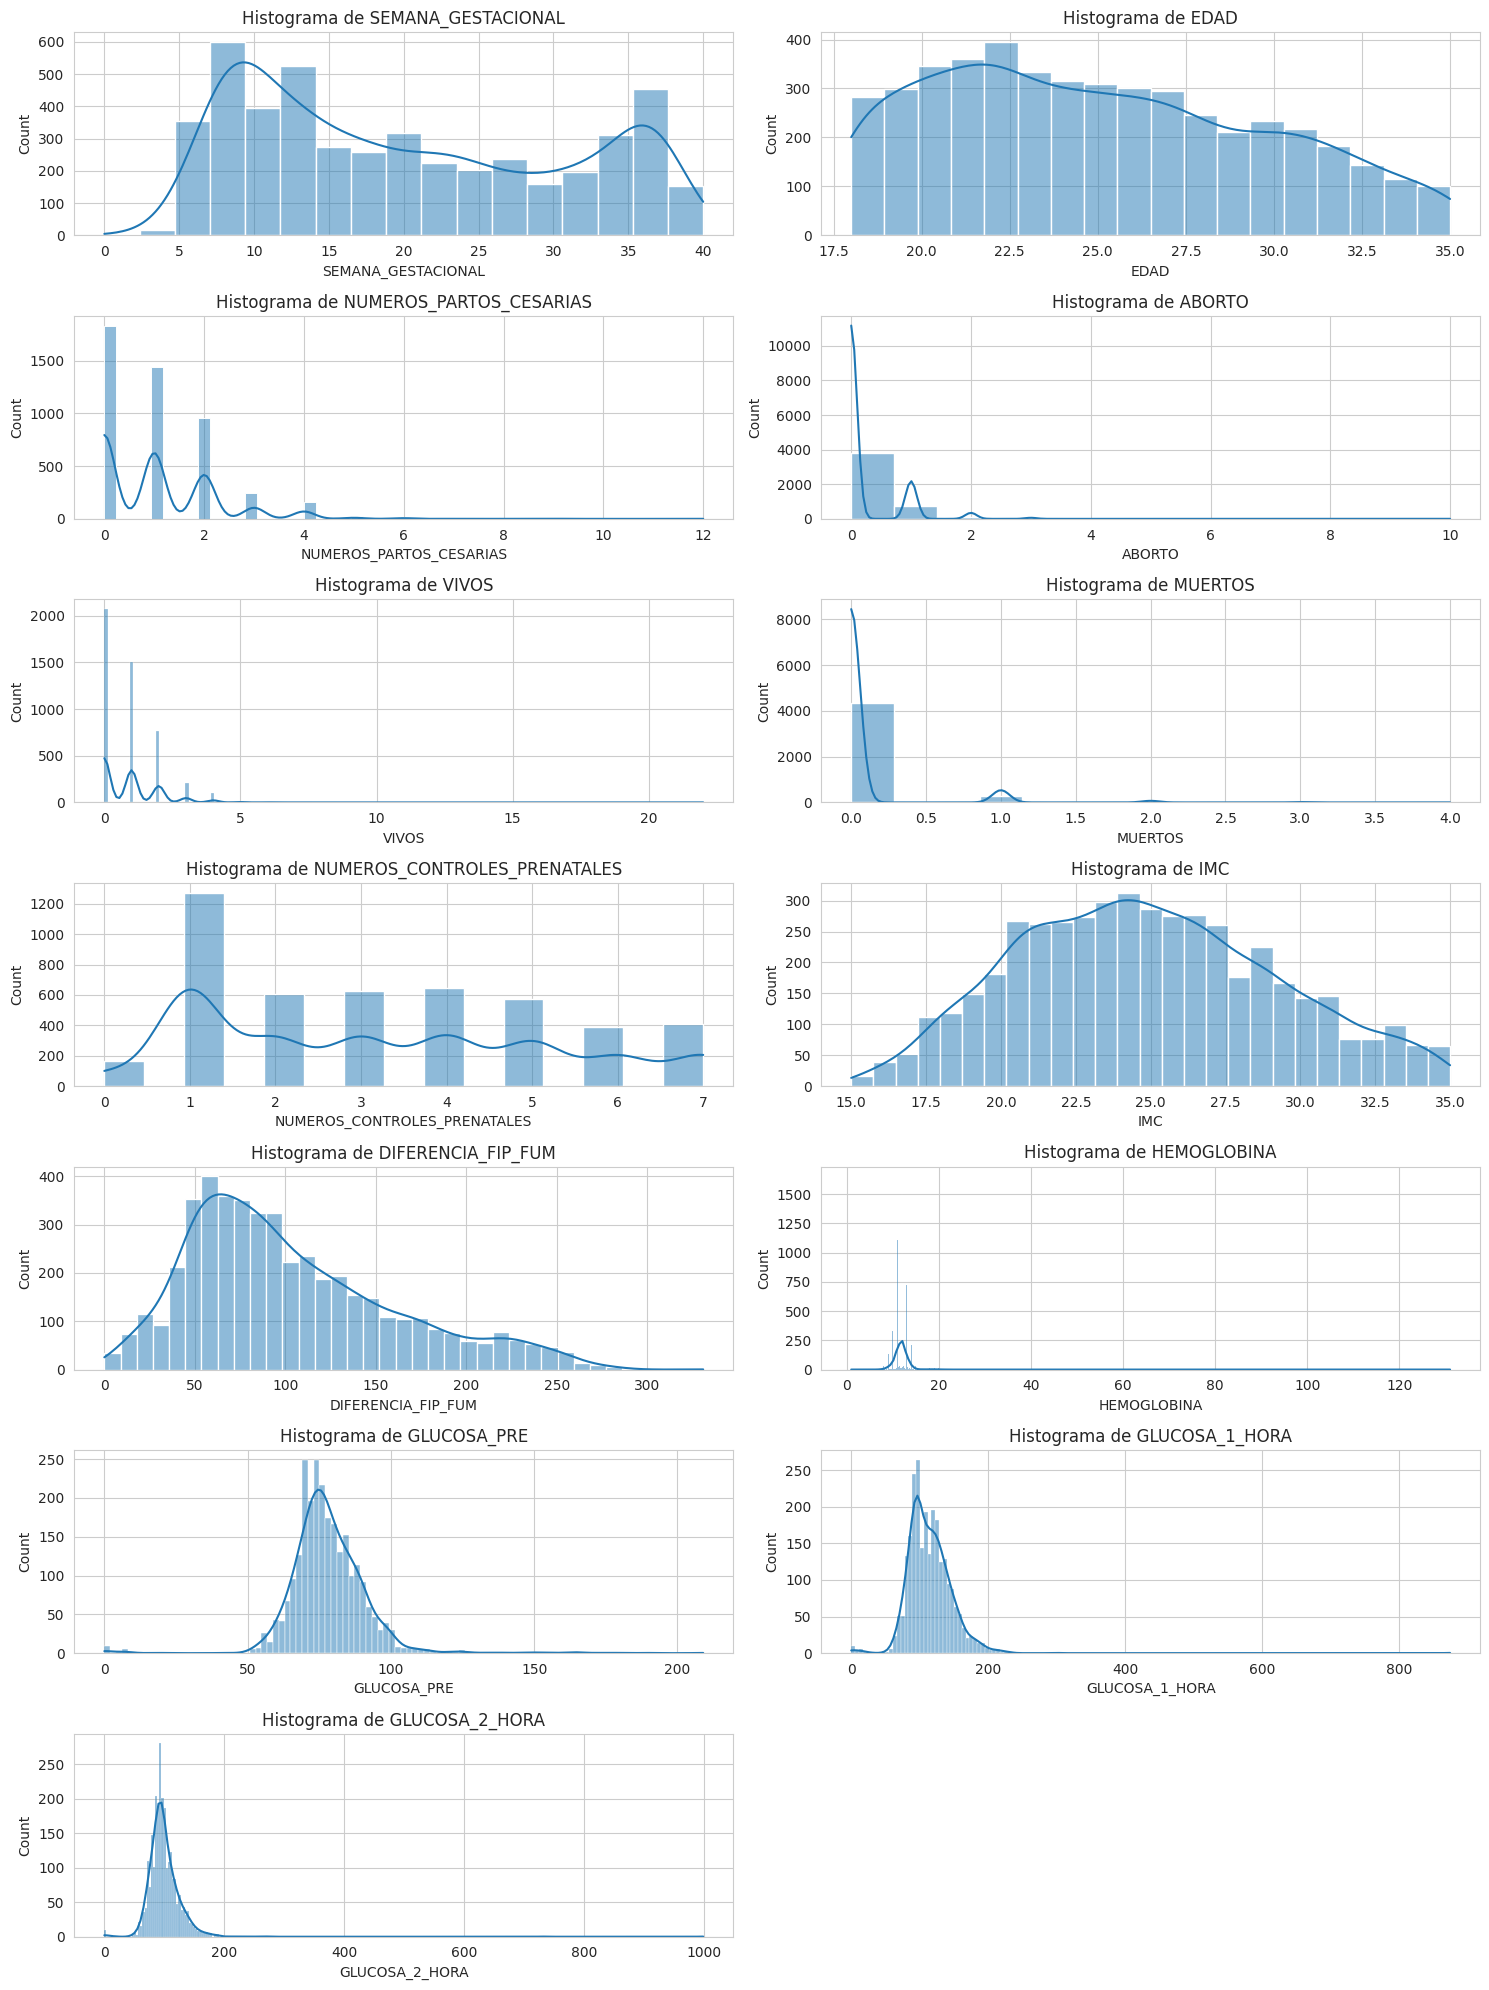

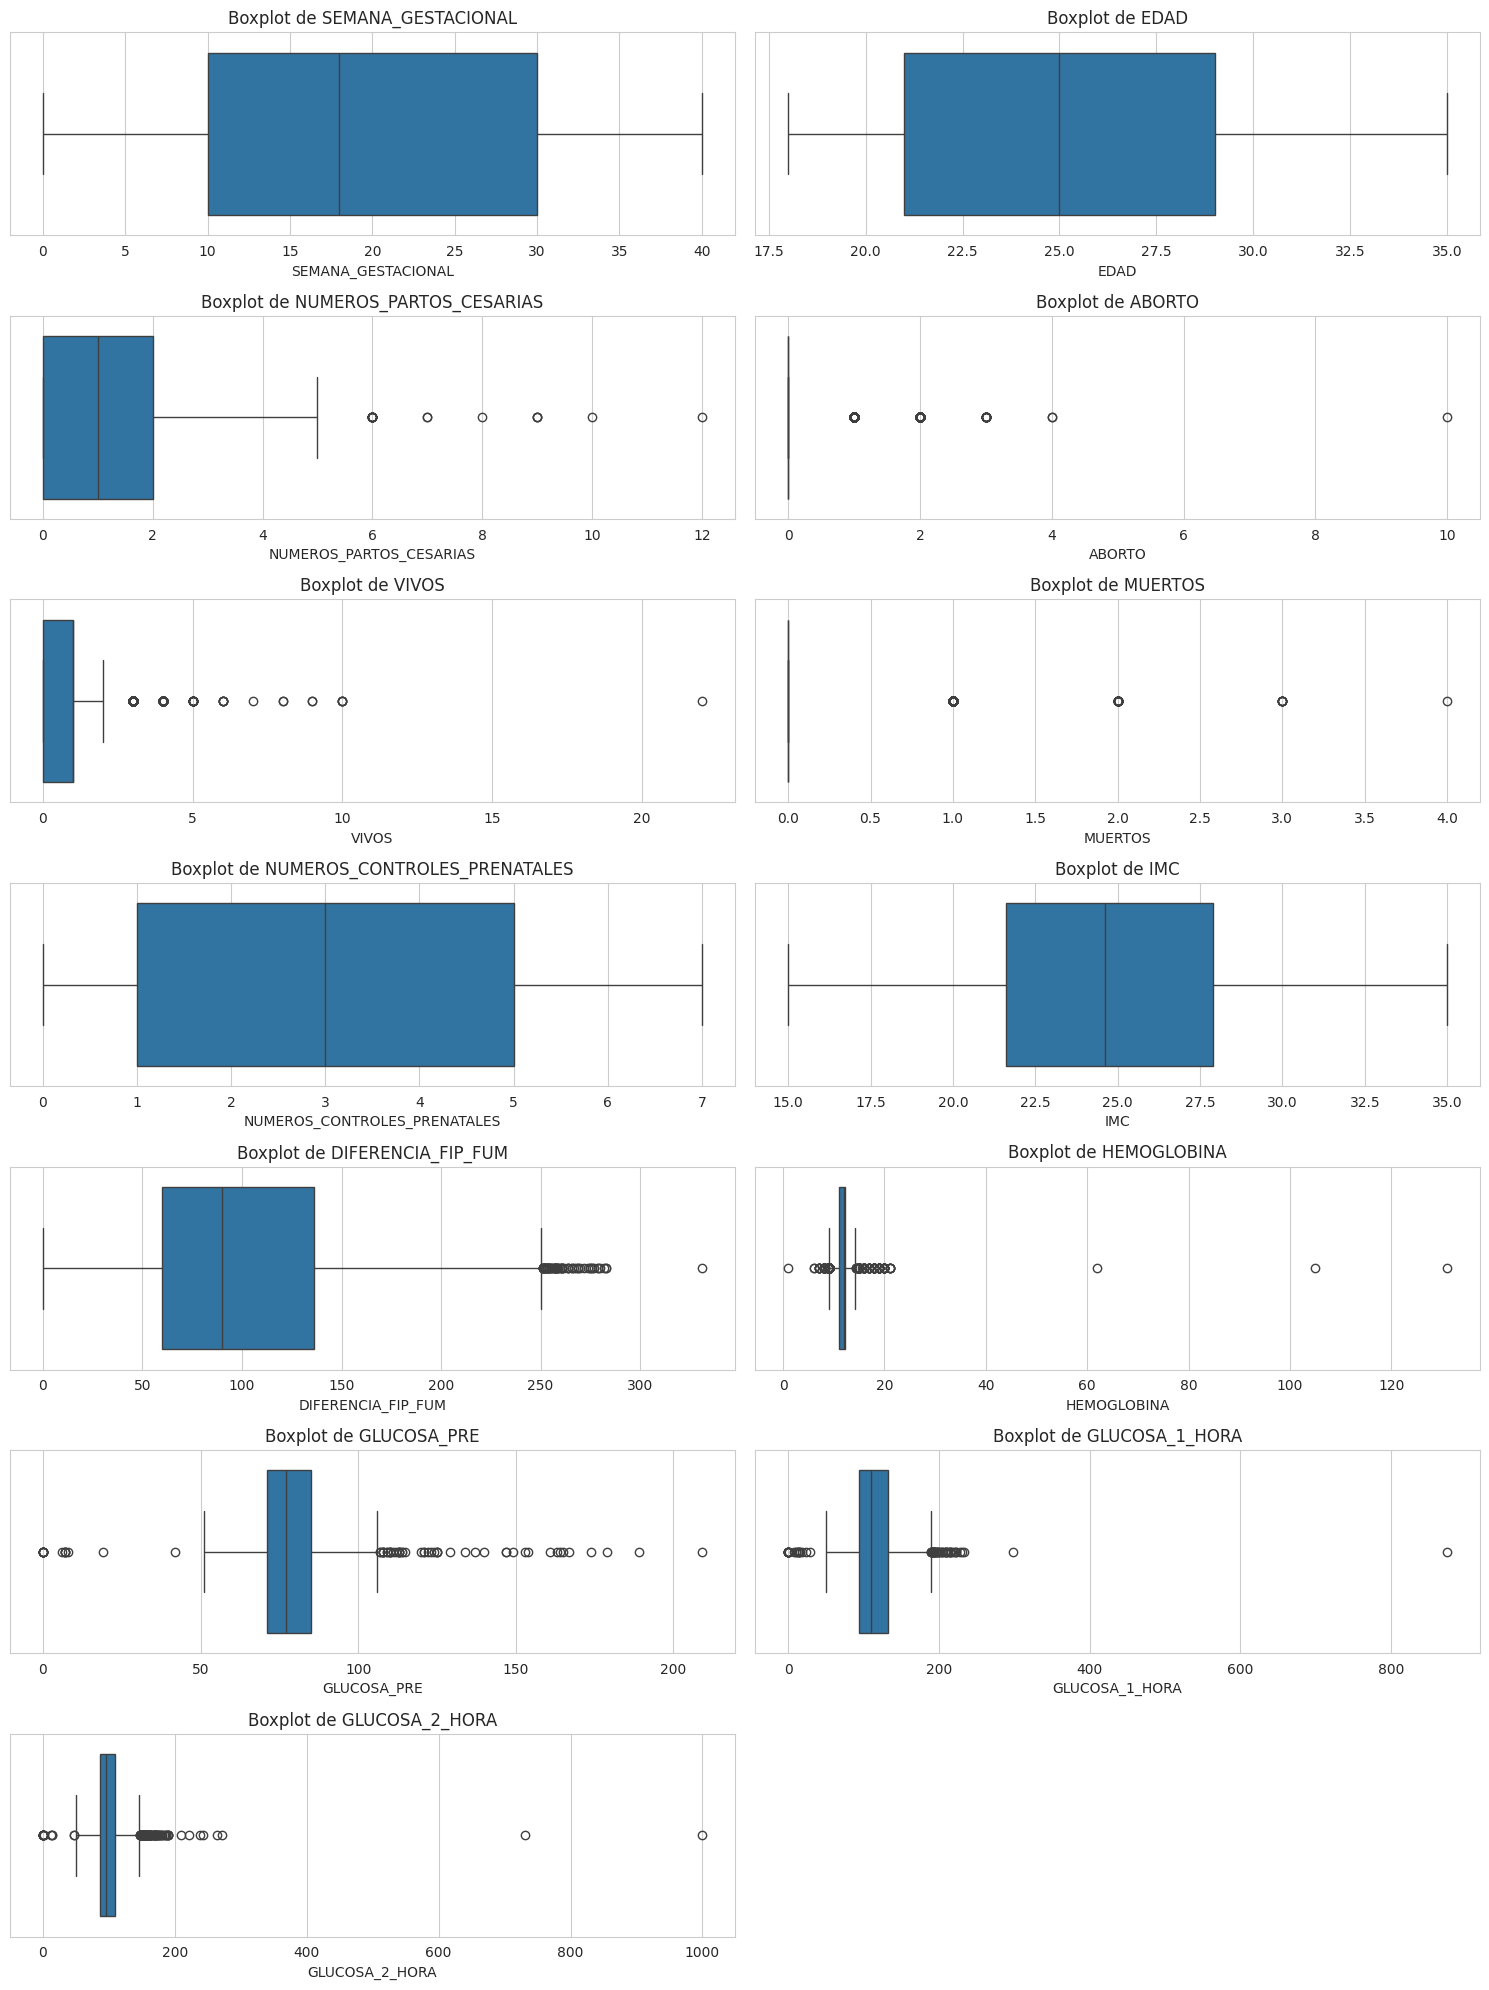

In [ ]:
df_filtrado_muestra = df_filtrado.sample(frac=0.1, random_state=42)

# Configuración de los gráficos
plt.figure(figsize=(15, 20))

# Histograms
for i, var in enumerate(numerical_features):
    plt.subplot(7, 2, i+1)
    sns.histplot(df_filtrado_muestra[var], kde=True)
    plt.title(f'Histograma de {var}')

plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(15, 20))

for i, var in enumerate(numerical_features):
    plt.subplot(7, 2, i+1)
    sns.boxplot(x=df_filtrado_muestra[var])
    plt.title(f'Boxplot de {var}')

plt.tight_layout()
plt.show()

In [ ]:
def asignar_trimestre(semana):
    if 0 <= semana <= 12:
        return 'Primer Trimestre'
    elif 13 <= semana <= 24:
        return 'Segundo Trimestre'
    elif semana >= 25:
        return 'Tercer Trimestre'
    else:
        return 'Semana Inválida'

# Aplicar la función a la columna SEMANA_GESTACIONAL para crear la nueva columna
df_smh['TRIMESTRE_GESTACIONAL'] = df_smh['SEMANA_GESTACIONAL'].apply(asignar_trimestre)

# Mostrar las primeras filas para verificar
df_smh[['SEMANA_GESTACIONAL', 'TRIMESTRE_GESTACIONAL']].head()

,SEMANA_GESTACIONAL,TRIMESTRE_GESTACIONAL
id_pac,,
CC1131479215,7.0,Primer Trimestre
CC1128044764,25.0,Tercer Trimestre
CC1053122184,31.0,Tercer Trimestre
CC1064982272,37.0,Tercer Trimestre
CC1221973807,14.0,Segundo Trimestre


In [ ]:
# Definir y aplicar la función de categorización
def asignar_trimestre(semana):
    if 0 <= semana <= 12:
        return 'Primer Trimestre'
    elif 13 <= semana <= 24:
        return 'Segundo Trimestre'
    elif semana >= 25:
        return 'Tercer Trimestre'
    else:
        return 'Semana Inválida'

# Crear la nueva columna categórica
df_filtrado['TRIMESTRE_GESTACIONAL'] = df_filtrado['SEMANA_GESTACIONAL'].apply(asignar_trimestre)

# Mostrar las primeras filas para verificar
df_filtrado[['SEMANA_GESTACIONAL', 'TRIMESTRE_GESTACIONAL']].head()

,SEMANA_GESTACIONAL,TRIMESTRE_GESTACIONAL
id_pac,,
CC1131479215,7.0,Primer Trimestre
CC1221973807,14.0,Segundo Trimestre
CC1085230510,19.0,Segundo Trimestre
CC1068817824,35.0,Tercer Trimestre
CC1042443708,31.0,Tercer Trimestre


In [ ]:
# Contar el número de casos por trimestre de gestación
conteo_por_trimestre = df_filtrado['TRIMESTRE_GESTACIONAL'].value_counts()

# Mostrar el resultado
conteo_por_trimestre

TRIMESTRE_GESTACIONAL
Primer Trimestre     15738
Tercer Trimestre     15545
Segundo Trimestre    15316
Semana Inválida        243
Name: count, dtype: int64

In [ ]:
df_primer_trimestre = df_filtrado[df_filtrado['TRIMESTRE_GESTACIONAL'] == 'Primer Trimestre']

In [ ]:
num_casos_primer_trimestre = df_primer_trimestre.shape[0]
print(f"Número de casos en el primer trimestre: {num_casos_primer_trimestre}")

Número de casos en el primer trimestre: 15738


In [ ]:
stats_primer_trimestre = df_primer_trimestre[numerical_features].describe().T
stats_primer_trimestre

,count,mean,std,min,25%,50%,75%,max
SEMANA_GESTACIONAL,15738.0,8.954262,2.013893,0.000000,8.000000,9.000000,11.000,12.00000
EDAD,15738.0,25.524082,4.563166,18.000000,22.000000,25.000000,29.000,35.00000
NUMEROS_PARTOS_CESARIAS,15737.0,0.934930,1.051646,0.000000,0.000000,1.000000,1.000,20.00000
NUMEROS_CONTROLES_PRENATALES,15738.0,3.615262,2.383318,0.000000,1.000000,4.000000,6.000,7.00000
IMC,15738.0,25.043265,4.331966,15.010751,21.778435,24.973985,28.125,34.99747
DIFERENCIA_FIP_FUM,15738.0,62.673338,35.435984,-305.000000,45.000000,58.000000,73.000,345.00000
GLUCOSA_PRE,7924.0,78.213907,12.273372,0.000000,71.000000,77.000000,85.000,216.00000
GLUCOSA_2_HORA,7902.0,101.022779,24.557952,0.000000,87.000000,97.000000,113.000,731.00000


In [ ]:
df_primer_trimestre_muestra = df_primer_trimestre.sample(frac=0.05, random_state=42)
df_primer_trimestre_muestra.shape

(787, 41)

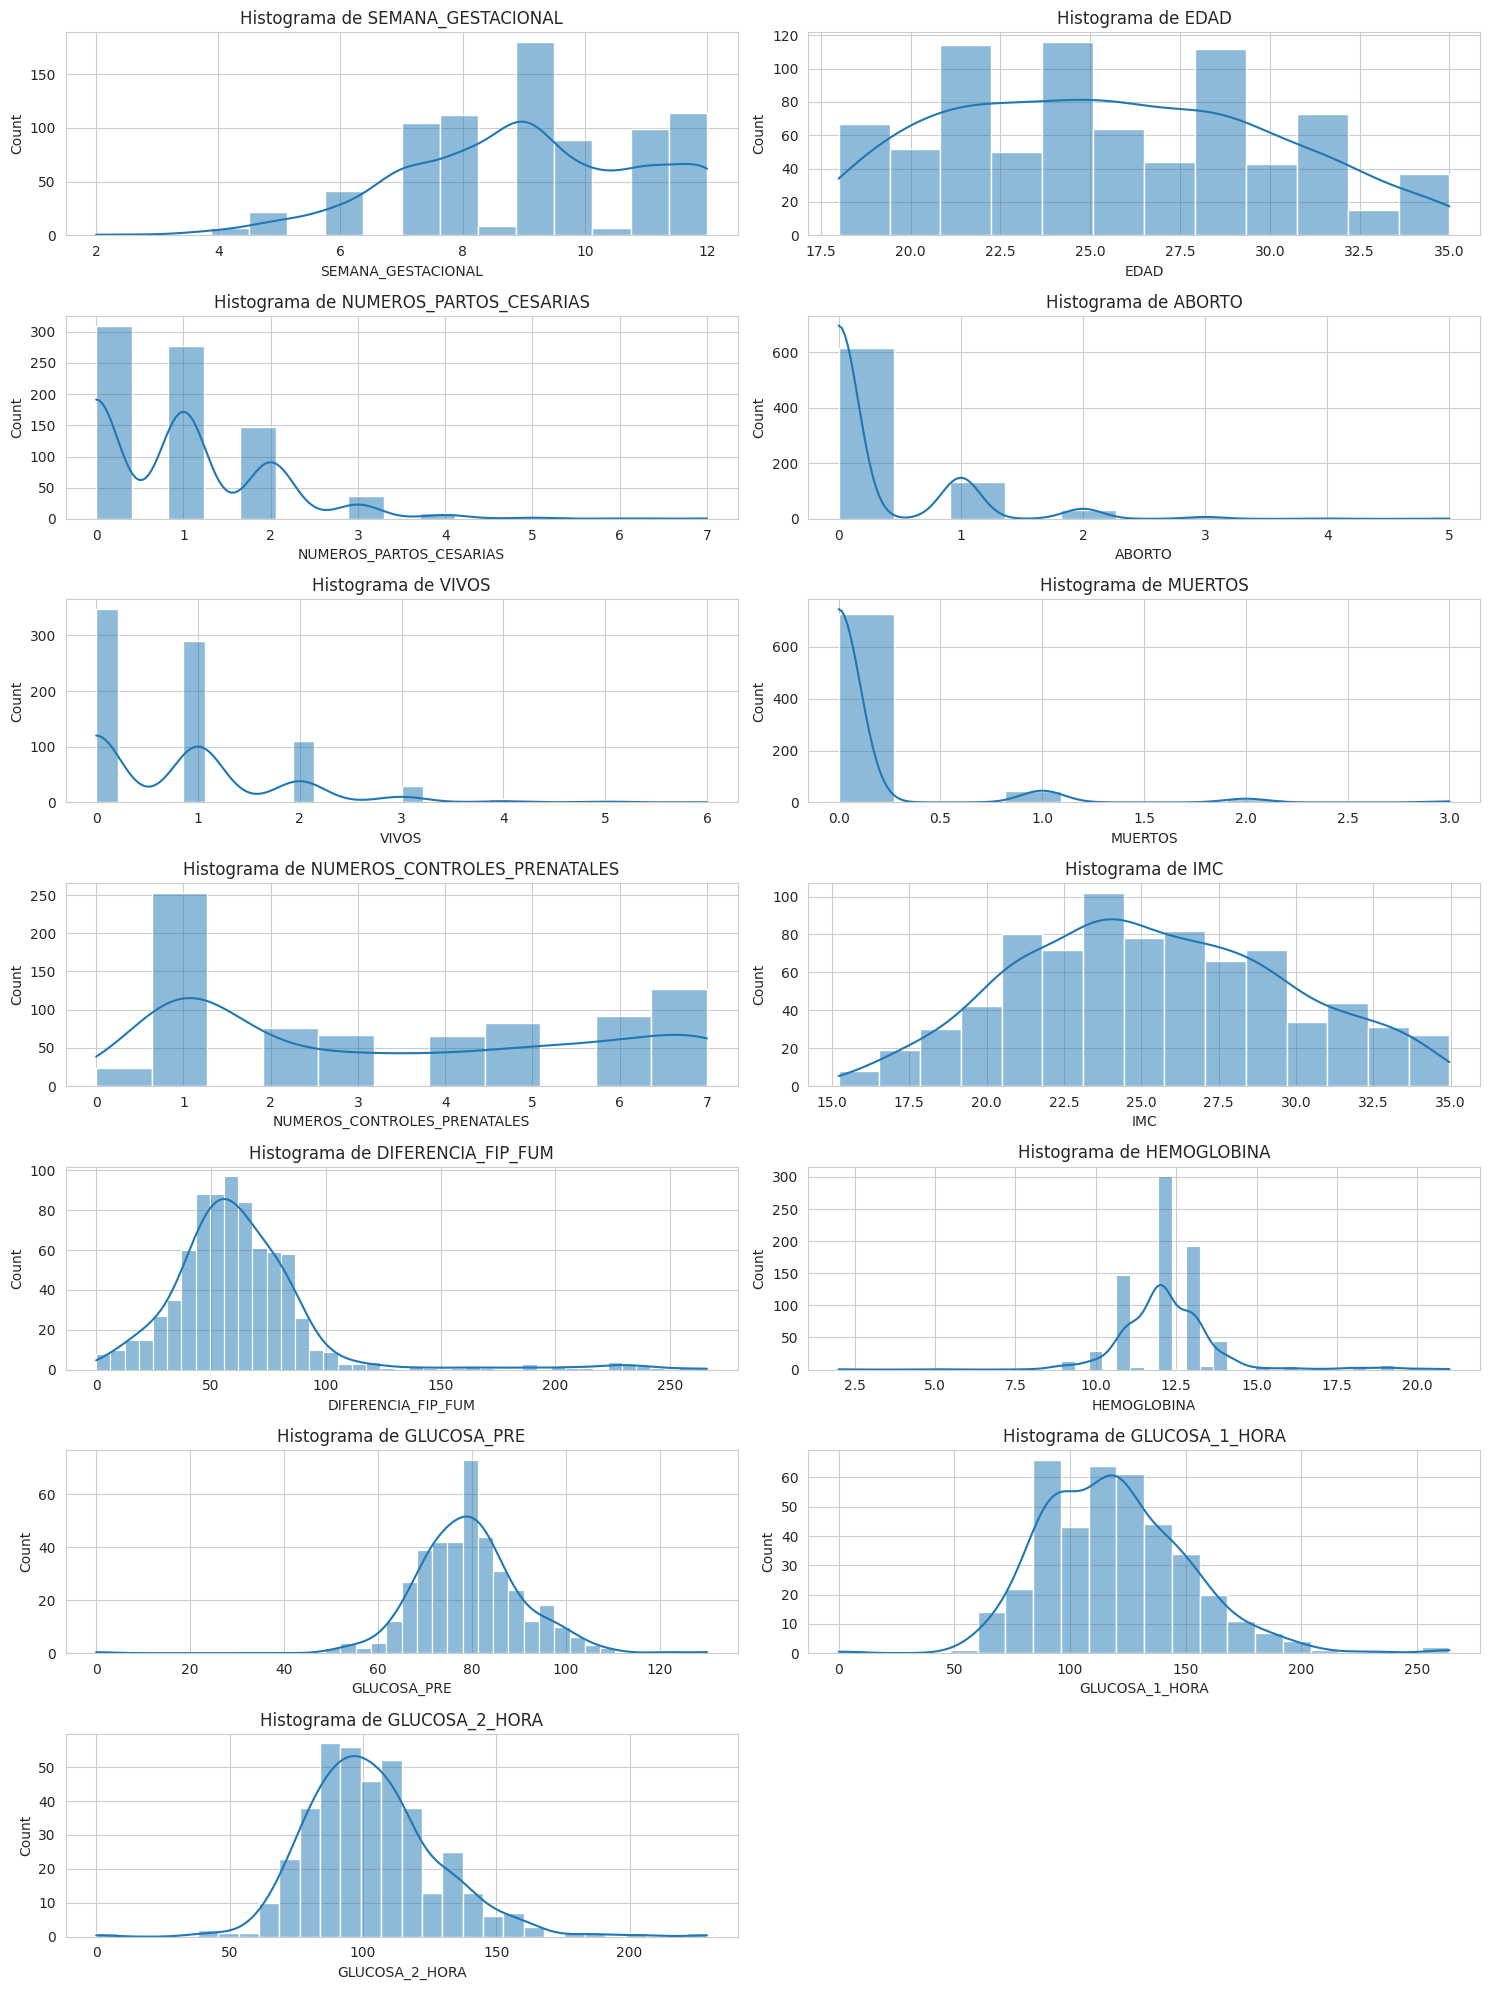

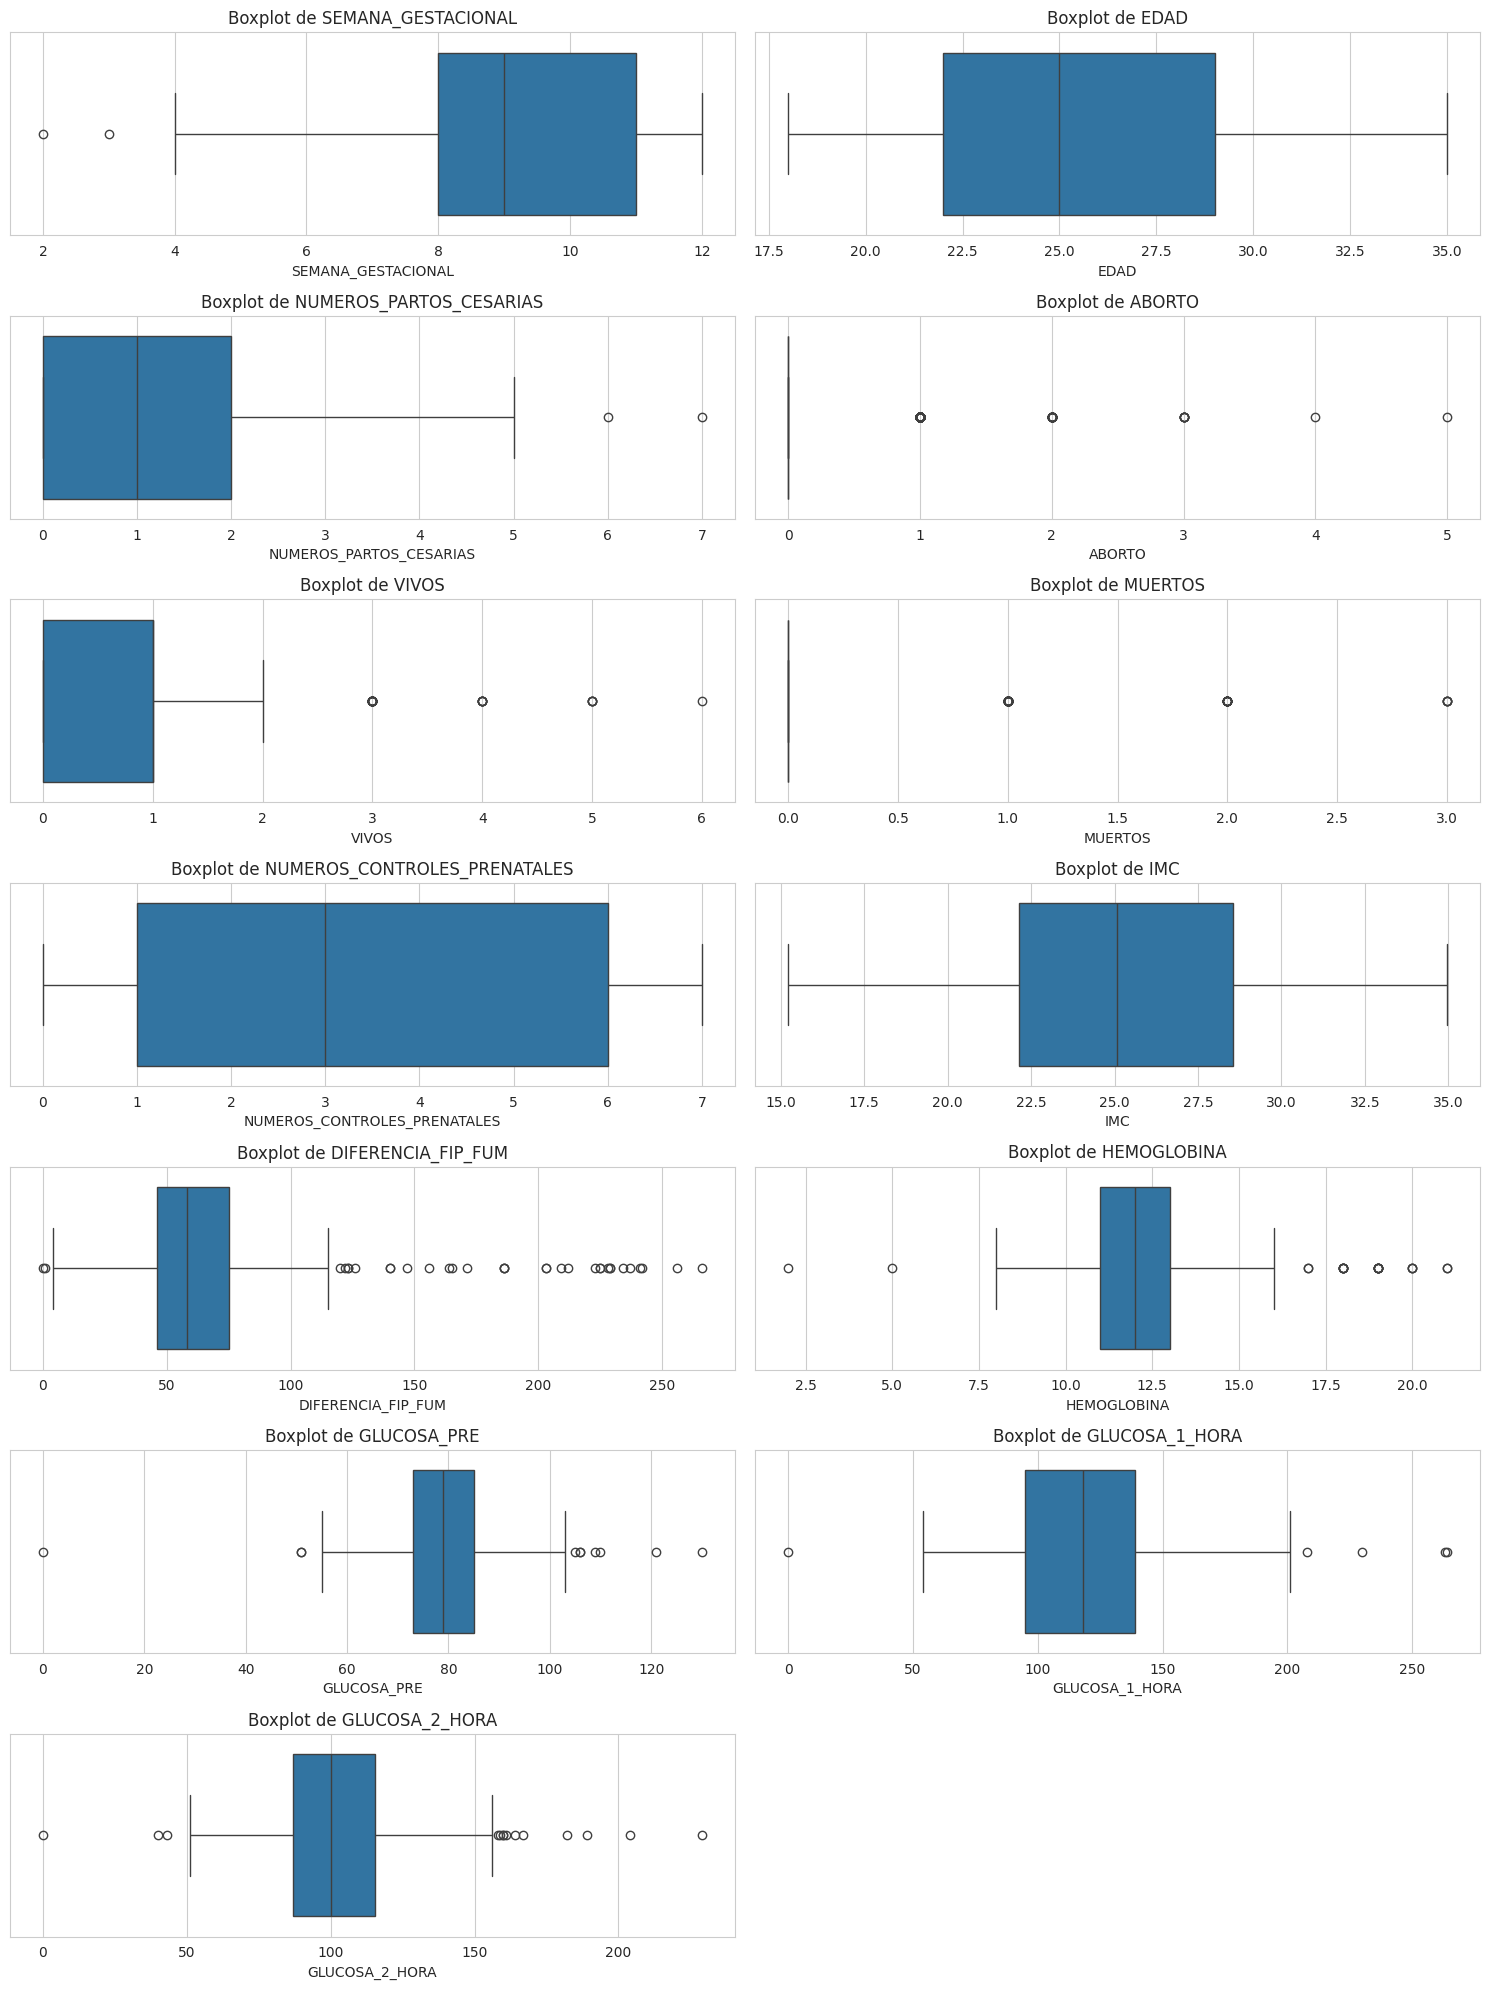

In [ ]:
# Configuración de los gráficos
plt.figure(figsize=(15, 20))

# Histograms
for i, var in enumerate(numerical_features):
    plt.subplot(7, 2, i+1)
    sns.histplot(df_primer_trimestre_muestra[var], kde=True)
    plt.title(f'Histograma de {var}')

plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(15, 20))

for i, var in enumerate(numerical_features):
    plt.subplot(7, 2, i+1)
    sns.boxplot(x=df_primer_trimestre_muestra[var])
    plt.title(f'Boxplot de {var}')

plt.tight_layout()
plt.show()

In [ ]:
df_primer_trimestre

,FUM,FPP,SEMANA_GESTACIONAL,EDAD,MAYOR_35,NUMEROS_PARTOS_CESARIAS,ABORTO,VIVOS,MUERTOS,RIESGO_PREECLAMPSIA,NUMEROS_CONTROLES_PRENATALES,IMC,RIESGO,CONSULTA_URGENCIA_ULTIMOS_30_DIAS,NACIONALIDAD_PROCEDENCIA,CODIGO_OCUPACION,NIVEL_EDUCATIVO,AFIC_GRUPO_ETNICO,AFIN_NIVEL_SISBEN,AFIN_GRUPO_POBLACIONAL,AFIC_ZONA,COD_MUNICIPIO,DIFERENCIA_FIP_FUM,HIPERTENSION,VIH_MATERNO_CONFIRMADO,TAMIZAJE_SIFILIS,TAMIZAJE_VIH,TAMIZAJE_HEPATITIS,DIAGNOSTICOS,HEMOGLOBINA,FECHA_HB,GLUCOSA_PRE,GLUCOSA_1_HORA,GLUCOSA_2_HORA,FECHA_GLUCOSA,HEMORRAGIA,POLIHIDRAMNIOS,MORTALIDAD_PERINATAL_NEONATAL_TARDIA_PREVIA,TRIMESTRE,ETIQUETA_MORBILIDAD,TRIMESTRE_GESTACIONAL
id_pac,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CC1131479215,2021-08-20 00:00:00,2022-06-01 00:00:00,7.0,19.0,0,0.0,0.0,0.0,0.0,2,6,17.577069,BAJO,2,2,58,10,5,3,17,0,3,52.0,0,0,1,1,1,658,12.0,2021-09-29 00:00:00,52.0,70.0,55.0,NaT,0,0,0,0,0,Primer Trimestre
CC1082491629,2023-02-10 00:00:00,2023-11-13 00:00:00,10.0,25.0,0,2.0,1.0,2.0,0.0,1,7,27.678739,BAJO,0,0,57,5,5,0,14,1,78,89.0,0,0,1,1,1,2990,11.0,2023-04-21 00:00:00,72.0,90.0,103.0,NaT,0,0,0,0,0,Primer Trimestre
CC1140836917,2021-11-18 00:00:00,2022-07-18 00:00:00,5.0,30.0,0,0.0,0.0,0.0,0.0,2,5,20.549887,BAJO,2,2,58,10,5,3,17,0,101,0.0,0,0,1,1,1,428,13.0,NaT,67.0,147.0,120.0,NaT,0,0,0,0,0,Primer Trimestre
CC1193123148,2022-07-04 00:00:00,2023-04-11 00:00:00,12.0,22.0,0,0.0,0.0,0.0,0.0,2,6,19.477147,BAJO,2,2,58,10,5,0,14,1,78,72.0,0,0,1,1,1,1456,12.0,2022-09-19 00:00:00,84.0,157.0,103.0,NaT,0,0,0,0,0,Primer Trimestre
PT4380492,2022-05-19 00:00:00,2023-02-22 00:00:00,9.0,22.0,0,2.0,0.0,1.0,1.0,2,7,26.485540,BAJO,2,2,58,10,5,3,12,1,101,61.0,0,0,1,1,1,2239,9.0,2022-07-14 00:00:00,83.0,86.0,83.0,NaT,0,0,0,0,0,Primer Trimestre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC1104257329,2022-08-21 00:00:00,2023-05-28 00:00:00,11.0,19.0,0,0.0,0.0,0.0,0.0,1,6,17.669297,ALTO,0,0,53,4,5,3,17,0,80,83.0,0,0,1,1,1,3191,12.0,2022-10-05 00:00:00,83.0,100.0,91.0,NaT,0,0,0,0,0,Primer Trimestre
CC1067947468,2022-11-12 00:00:00,2023-08-19 00:00:00,6.0,26.0,0,0.0,0.0,0.0,0.0,2,4,29.744200,ALTO,2,2,58,10,5,0,14,1,39,46.0,0,0,0,0,1,2239,12.0,NaT,96.0,155.0,129.0,NaT,0,0,0,0,1,Primer Trimestre
CC1079885220,2023-10-28 00:00:00,2024-08-03 00:00:00,12.0,18.0,0,0.0,0.0,0.0,0.0,1,1,24.767566,ALTO,0,0,56,2,5,0,14,1,105,67.0,0,0,1,1,1,2988,13.0,2024-01-15 00:00:00,NaN,NaN,NaN,NaT,0,0,0,0,0,Primer Trimestre


> Pasos siguientes:

* Analisis de asociación de variables numéricas con variable objetivo
* identificación de predictores (variables numéricas) candidatos para MME
* unificar predictores candidatos (num y cat) para MME
* Evaluar multicolinealidad entre los candidatos
* Seleccionar Predictores
* Estimar ecuación de regresion logistica binaria para MME
* Validar resultados preliminares con experto de negocio

In [ ]:
# Variable objetivo
target = 'ETIQUETA_MORBILIDAD'

# Limpiar los datos eliminando filas con NaNs en las variables numéricas y la variable objetivo
df_clean = df_primer_trimestre[numerical_features + [target]].dropna()

# Análisis de correlación punto-biserial
correlations = {}
for feature in numerical_features:
    corr, p_value = pointbiserialr(df_clean[feature], df_clean[target])
    correlations[feature] = (corr, p_value)

# Convertir a DataFrame para visualización
correlation_df = pd.DataFrame(correlations, index=['Correlation', 'P-value']).T
correlation_df.sort_values(by='Correlation', ascending=False, inplace=True)

# Visualizar el DataFrame
print(correlation_df)

                              Correlation   P-value
IMC                              0.045422  0.000056
GLUCOSA_1_HORA                   0.032860  0.003563
GLUCOSA_2_HORA                   0.025402  0.024271
HEMOGLOBINA                      0.014218  0.207381
GLUCOSA_PRE                      0.000360  0.974520
ABORTO                           0.000084  0.994084
NUMEROS_CONTROLES_PRENATALES    -0.006528  0.562668
EDAD                            -0.006979  0.536002
NUMEROS_PARTOS_CESARIAS         -0.009303  0.409423
MUERTOS                         -0.019661  0.081241
SEMANA_GESTACIONAL              -0.020066  0.075168
VIVOS                           -0.023671  0.035795
DIFERENCIA_FIP_FUM              -0.024539  0.029540


Las variables con correlación significativa (IMC, GLUCOSA_1_HORA, GLUCOSA_2_HORA, VIVOS, y DIFERENCIA_FIP_FUM) podrían ser consideradas como predictores candidatos para la construcción de un modelo predictivo de morbilidad materna extrema.

In [ ]:
df_primer_trimestre_signif = df_primer_trimestre[['IMC','GLUCOSA_1_HORA', 'GLUCOSA_2_HORA', 'VIVOS','DIFERENCIA_FIP_FUM','NIVEL_EDUCATIVO', 'CONSULTA_URGENCIA_ULTIMOS_30_DIAS', 'RIESGO_PREECLAMPSIA',
    'NACIONALIDAD_PROCEDENCIA', 'COD_MUNICIPIO', 'HIPERTENSION', 'DIAGNOSTICOS',
    'MAYOR_35', 'AFIC_ZONA', 'CODIGO_OCUPACION', 'AFIC_GRUPO_ETNICO', 'AFIN_GRUPO_POBLACIONAL',
    'AFIN_NIVEL_SISBEN', 'TAMIZAJE_VIH', 'TAMIZAJE_SIFILIS','ETIQUETA_MORBILIDAD']]
df_primer_trimestre_signif.shape

(15738, 21)

In [ ]:
df_primer_trimestre_signif

,IMC,GLUCOSA_1_HORA,GLUCOSA_2_HORA,VIVOS,DIFERENCIA_FIP_FUM,NIVEL_EDUCATIVO,CONSULTA_URGENCIA_ULTIMOS_30_DIAS,RIESGO_PREECLAMPSIA,NACIONALIDAD_PROCEDENCIA,COD_MUNICIPIO,HIPERTENSION,DIAGNOSTICOS,MAYOR_35,AFIC_ZONA,CODIGO_OCUPACION,AFIC_GRUPO_ETNICO,AFIN_GRUPO_POBLACIONAL,AFIN_NIVEL_SISBEN,TAMIZAJE_VIH,TAMIZAJE_SIFILIS,ETIQUETA_MORBILIDAD
id_pac,,,,,,,,,,,,,,,,,,,,,
CC1131479215,17.577069,70.0,55.0,0.0,52.0,10,2,2,2,3,0,658,0,0,58,5,17,3,1,1,0
CC1082491629,27.678739,90.0,103.0,2.0,89.0,5,0,1,0,78,0,2990,0,1,57,5,14,0,1,1,0
CC1140836917,20.549887,147.0,120.0,0.0,0.0,10,2,2,2,101,0,428,0,0,58,5,17,3,1,1,0
CC1193123148,19.477147,157.0,103.0,0.0,72.0,10,2,2,2,78,0,1456,0,1,58,5,14,0,1,1,0
PT4380492,26.485540,86.0,83.0,1.0,61.0,10,2,2,2,101,0,2239,0,1,58,5,12,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC1104257329,17.669297,100.0,91.0,0.0,83.0,4,0,1,0,80,0,3191,0,0,53,5,17,3,1,1,0
CC1067947468,29.744200,155.0,129.0,0.0,46.0,10,2,2,2,39,0,2239,0,1,58,5,14,0,0,0,1
CC1079885220,24.767566,NaN,NaN,0.0,67.0,2,0,1,0,105,0,2988,0,1,56,5,14,0,1,1,0


In [ ]:
df_primer_trimestre_signif = df_primer_trimestre_signif.dropna()
df_primer_trimestre_signif.shape

(7900, 21)

In [ ]:
# Variables categóricas, numéricas y de fecha
categorical_features = [ 'NIVEL_EDUCATIVO', 'CONSULTA_URGENCIA_ULTIMOS_30_DIAS', 'MAYOR_35','AFIC_ZONA', 'CODIGO_OCUPACION', 'AFIC_GRUPO_ETNICO', 'AFIN_GRUPO_POBLACIONAL',
    'AFIN_NIVEL_SISBEN', 'TAMIZAJE_VIH', 'TAMIZAJE_SIFILIS']

numerical_features = [ 'IMC', 'GLUCOSA_1_HORA', 'GLUCOSA_2_HORA', 'VIVOS', 'DIFERENCIA_FIP_FUM']

date_features = ['FUM', 'FPP', 'FECHA_HB', 'FECHA_GLUCOSA']

# Convertir variables de fecha
for col in date_features:
    try:
        df_primer_trimestre_signif.loc[:, col] = pd.to_datetime(df_primer_trimestre_signif[col], errors='coerce')
    except KeyError as e:
        print(f"Error: La columna {e} no está presente en el DataFrame.")
    except Exception as e:
        print(f"Se ha producido un error inesperado al convertir {col}: {e}")

# Convertir variables categóricas a string
for col in categorical_features:
    try:
        df_primer_trimestre_signif.loc[:, col] = df_primer_trimestre_signif[col].astype(str)
    except KeyError as e:
        print(f"Error: La columna {e} no está presente en el DataFrame.")
    except Exception as e:
        print(f"Se ha producido un error inesperado al convertir {col}: {e}")

# Convertir variables numéricas a numérico
for col in numerical_features:
    try:
        df_primer_trimestre_signif.loc[:, col] = pd.to_numeric(df_primer_trimestre_signif[col], errors='coerce')
    except KeyError as e:
        print(f"Error: La columna {e} no está presente en el DataFrame.")
    except Exception as e:
        print(f"Se ha producido un error inesperado al convertir {col}: {e}")

# Confirmar conversiones
df_primer_trimestre_signif.info()

Error: La columna 'FUM' no está presente en el DataFrame.
Error: La columna 'FPP' no está presente en el DataFrame.
Error: La columna 'FECHA_HB' no está presente en el DataFrame.
Error: La columna 'FECHA_GLUCOSA' no está presente en el DataFrame.
<class 'pandas.core.frame.DataFrame'>
Index: 7900 entries, CC1131479215 to CC1102838061
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IMC                                7900 non-null   float64
 1   GLUCOSA_1_HORA                     7900 non-null   object 
 2   GLUCOSA_2_HORA                     7900 non-null   float64
 3   VIVOS                              7900 non-null   object 
 4   DIFERENCIA_FIP_FUM                 7900 non-null   float64
 5   NIVEL_EDUCATIVO                    7900 non-null   object 
 6   CONSULTA_URGENCIA_ULTIMOS_30_DIAS  7900 non-null   object 
 7   RIESGO_PREECLAMPSIA                7900 non-null   

In [ ]:
# Intentar convertir la columna GLUCOSA_1_HORA a numérica y capturar los errores
df_primer_trimestre_signif['GLUCOSA_1_HORA_numeric'] = pd.to_numeric(df_primer_trimestre_signif['GLUCOSA_1_HORA'], errors='coerce')

# Identificar las celdas que no se pudieron transformar
non_numeric_glucosa_1_hora = df_primer_trimestre_signif[df_primer_trimestre_signif['GLUCOSA_1_HORA_numeric'].isna()]['GLUCOSA_1_HORA']

# Mostrar los valores de las celdas problemáticas
print("Celdas que no se pudieron transformar en numéricas en la columna GLUCOSA_1_HORA:")
print(non_numeric_glucosa_1_hora)

# Reemplazar la columna original con la convertida
df_primer_trimestre_signif['GLUCOSA_1_HORA'] = df_primer_trimestre_signif['GLUCOSA_1_HORA_numeric']
df_primer_trimestre_signif.drop(columns=['GLUCOSA_1_HORA_numeric'], inplace=True)

Celdas que no se pudieron transformar en numéricas en la columna GLUCOSA_1_HORA:
Series([], Name: GLUCOSA_1_HORA, dtype: object)


<ipython-input-37-481a7406dc31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_primer_trimestre_signif['GLUCOSA_1_HORA_numeric'] = pd.to_numeric(df_primer_trimestre_signif['GLUCOSA_1_HORA'], errors='coerce')
<ipython-input-37-481a7406dc31>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_primer_trimestre_signif['GLUCOSA_1_HORA'] = df_primer_trimestre_signif['GLUCOSA_1_HORA_numeric']
<ipython-input-37-481a7406dc31>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Manejo de valores faltantes
# Puedes optar por eliminar filas con valores faltantes o imputar esos valores
df_primer_trimestre_signif.dropna(inplace=True)

# 2. Conversión de tipos de datos
# Convertir columnas numéricas que están como object a numéricas
numerical_features = ['IMC', 'GLUCOSA_1_HORA', 'GLUCOSA_2_HORA', 'VIVOS', 'DIFERENCIA_FIP_FUM']

for column in numerical_features:
    df_primer_trimestre_signif[column] = pd.to_numeric(df_primer_trimestre_signif[column], errors='coerce')

# Identificar y mostrar celdas que no se pudieron transformar a numéricas
for column in numerical_features:
    non_numeric_values = df_primer_trimestre_signif[df_primer_trimestre_signif[column].isna()][column]
    if not non_numeric_values.empty:
        print(f"Celdas que no se pudieron transformar en numéricas en la columna {column}:")
        print(non_numeric_values)

# Volver a eliminar filas con valores NaN después de la conversión
df_primer_trimestre_signif.dropna(inplace=True)

# 3. Codificación de variables categóricas
categorical_features = ['NIVEL_EDUCATIVO', 'CONSULTA_URGENCIA_ULTIMOS_30_DIAS', 'MAYOR_35', 'AFIC_ZONA',
                        'CODIGO_OCUPACION', 'AFIC_GRUPO_ETNICO', 'AFIN_GRUPO_POBLACIONAL',
                        'AFIN_NIVEL_SISBEN', 'TAMIZAJE_VIH', 'TAMIZAJE_SIFILIS']

df_primer_trimestre_signif = pd.get_dummies(df_primer_trimestre_signif, columns=categorical_features, drop_first=True)

# 4. Escalado de variables
scaler = StandardScaler()
df_primer_trimestre_signif[numerical_features] = scaler.fit_transform(df_primer_trimestre_signif[numerical_features])

# 5. División del dataset
# Supongamos que la variable objetivo se llama 'ETIQUETA_MORBILIDAD'
target = 'ETIQUETA_MORBILIDAD'
X = df_primer_trimestre_signif.drop(columns=[target])
y = df_primer_trimestre_signif[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificación final
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

<ipython-input-38-cec0f2bd0d61>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_primer_trimestre_signif.dropna(inplace=True)
<ipython-input-38-cec0f2bd0d61>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_primer_trimestre_signif[column] = pd.to_numeric(df_primer_trimestre_signif[column], errors='coerce')
<ipython-input-38-cec0f2bd0d61>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Tamaño del conjunto de entrenamiento: (6320, 66)
Tamaño del conjunto de prueba: (1580, 66)


In [ ]:
for column in numerical_features:
    df_primer_trimestre_signif[column] = pd.to_numeric(df_primer_trimestre_signif[column], errors='coerce')

In [ ]:
df_primer_trimestre_signif

# = pd.get_dummies(df_primer_trimestre_signif, columns=categorical_features, drop_first=True)

,IMC,GLUCOSA_1_HORA,GLUCOSA_2_HORA,VIVOS,DIFERENCIA_FIP_FUM,RIESGO_PREECLAMPSIA,NACIONALIDAD_PROCEDENCIA,COD_MUNICIPIO,HIPERTENSION,DIAGNOSTICOS,ETIQUETA_MORBILIDAD,NIVEL_EDUCATIVO_1,NIVEL_EDUCATIVO_10,NIVEL_EDUCATIVO_2,NIVEL_EDUCATIVO_3,NIVEL_EDUCATIVO_4,NIVEL_EDUCATIVO_5,NIVEL_EDUCATIVO_6,NIVEL_EDUCATIVO_7,NIVEL_EDUCATIVO_8,CONSULTA_URGENCIA_ULTIMOS_30_DIAS_1,CONSULTA_URGENCIA_ULTIMOS_30_DIAS_2,MAYOR_35_1,AFIC_ZONA_1,CODIGO_OCUPACION_12,CODIGO_OCUPACION_14,CODIGO_OCUPACION_15,CODIGO_OCUPACION_17,CODIGO_OCUPACION_18,CODIGO_OCUPACION_22,CODIGO_OCUPACION_25,CODIGO_OCUPACION_28,CODIGO_OCUPACION_3,CODIGO_OCUPACION_34,CODIGO_OCUPACION_36,CODIGO_OCUPACION_37,CODIGO_OCUPACION_38,CODIGO_OCUPACION_41,CODIGO_OCUPACION_42,CODIGO_OCUPACION_43,CODIGO_OCUPACION_46,CODIGO_OCUPACION_47,CODIGO_OCUPACION_49,CODIGO_OCUPACION_50,CODIGO_OCUPACION_53,CODIGO_OCUPACION_54,CODIGO_OCUPACION_56,CODIGO_OCUPACION_57,CODIGO_OCUPACION_58,CODIGO_OCUPACION_8,AFIC_GRUPO_ETNICO_2,AFIC_GRUPO_ETNICO_3,AFIC_GRUPO_ETNICO_4,AFIC_GRUPO_ETNICO_5,AFIN_GRUPO_POBLACIONAL_11,AFIN_GRUPO_POBLACIONAL_12,AFIN_GRUPO_POBLACIONAL_13,AFIN_GRUPO_POBLACIONAL_14,AFIN_GRUPO_POBLACIONAL_17,AFIN_GRUPO_POBLACIONAL_4,AFIN_GRUPO_POBLACIONAL_6,AFIN_GRUPO_POBLACIONAL_9,AFIN_NIVEL_SISBEN_1,AFIN_NIVEL_SISBEN_2,AFIN_NIVEL_SISBEN_3,TAMIZAJE_VIH_1,TAMIZAJE_SIFILIS_1
id_pac,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CC1131479215,-1.798265,-1.547736,-1.874140,-0.896731,-0.342699,2,2,3,0,658,0,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,True,True
CC1082491629,0.593089,-0.890410,0.080683,1.202906,0.548978,1,0,78,0,2990,0,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,True
CC1140836917,-1.094514,0.982968,0.773016,-0.896731,-1.595867,2,2,101,0,428,0,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,True,True
CC1193123148,-1.348462,1.311631,0.080683,-0.896731,0.139288,2,2,78,0,1456,0,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,True
PT4380492,0.310624,-1.021875,-0.733827,0.153087,-0.125805,2,2,101,0,2239,0,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC1143245593,1.726109,-0.561747,-0.489474,-0.896731,-0.824687,1,0,101,0,2988,0,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,Fals

Las variables IMC, GLUCOSA_2_HORA, y DIFERENCIA_FIP_FUM tienen valores de VIF muy bajos (alrededor de 1), lo que sugiere que no hay multicolinealidad significativa entre ellas.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Convertir variables categóricas significativas a dummies
categorical_features_significant = [
    'NIVEL_EDUCATIVO', 'CONSULTA_URGENCIA_ULTIMOS_30_DIAS', 'RIESGO_PREECLAMPSIA',
    'NACIONALIDAD_PROCEDENCIA', 'COD_MUNICIPIO', 'HIPERTENSION', 'DIAGNOSTICOS',
    'MAYOR_35', 'AFIC_ZONA', 'CODIGO_OCUPACION', 'AFIC_GRUPO_ETNICO', 'AFIN_GRUPO_POBLACIONAL',
    'AFIN_NIVEL_SISBEN', 'TAMIZAJE_VIH', 'TAMIZAJE_SIFILIS'
]

# Crear un DataFrame con las variables significativas
df_significant = df_smh[['IMC', 'GLUCOSA_1_HORA', 'GLUCOSA_2_HORA', 'VIVOS', 'DIFERENCIA_FIP_FUM'] + categorical_features_significant]

# Convertir variables categóricas a dummies
df_significant = pd.get_dummies(df_significant, columns=categorical_features_significant, drop_first=True)

# Convertir todas las columnas a tipo numérico (coercionando cualquier error a NaN)
df_significant = df_significant.apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores NaN o infinitos
df_significant.replace([np.inf, -np.inf], np.nan, inplace=True)
df_significant.dropna(inplace=True)

# Calcular el VIF
X = add_constant(df_significant)  # Agregar constante para el cálculo de VIF

# Asegurarse de que todas las columnas sean numéricas
assert np.issubdtype(X.values.dtype, np.number), "All columns must be numeric"

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Mostrar resultados del VIF
vif_data.sort_values(by="VIF", ascending=False, inplace=True)
print(vif_data)

Las variables que muestran valor como predictores en el modelo de marcación de riesgo de Morbilidad Materna Extrema son:
* NIVEL_EDUCATIVO
* CONSULTA_URGENCIA_ULTIMOS_30_DIAS
* RIESGO_PREECLAMPSIA
* IMC(Sem12)
* GLUCOSA_1_HORA
* GLUCOSA_2_HORA
* VIVOS
* DIFERENCIA FIP - FUM

Compromisos:

*   REvisar variable FIP - FUM
*   Revisar si las menores de edadse pueden incluir en el estudio
*   Contrucción de documento paara envio doctora Martha

In [ ]:
Compromisos:
Fecha ingreso programa
Fecha probable de parto
Construcción de documento